Проект, данные которого были использованы: https://github.com/paperscape/paperscape-data

Авторы:
* Rob Knegjens, rknegjens@gmail.com
* Damien George, damien.p.george@gmail.com

**Внимание**. Требуется 13 ГБ оперативы для полного выполнения скрипта. В противном случае, может понадобится swap-раздел.

In [1]:
from arxiv import load_arxiv, ArxivTags, get_density_graph
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import networkx as nx
from collections import Counter

lines = '''
Astrophysics (astro-ph)
Condensed Matter (cond-mat)
Computer Science (cs)
Economics (econ)
Electrical Engineering and Systems Science (eess)
General Relativity and Quantum Cosmology (gr-qc)
High Energy Physics - Experiment (hep-ex)
High Energy Physics - Lattice (hep-lat)
High Energy Physics - Phenomenology (hep-ph)
High Energy Physics - Theory (hep-th)
Mathematics (math)
Mathematical Physics (math-ph)
Nonlinear Sciences (nlin)
Nuclear Experiment (nucl-ex)
Nuclear Theory (nucl-th)
Physics (physics)
Quantitative Biology (q-bio)
Quantitative Finance (q-fin)
Quantum Physics (quant-ph)
Statistics (stat)
'''.split('\n')

deprecated = '''
Accelerator Physics (acc-phys, subsumed into physics.acc-ph)
Adaptation, Noise, and Self-Organizing Systems (adap-org, subsumed into nlin.AO)
Algebraic Geometry (alg-geom, subsumed into math.AG)
Atmospheric-Oceanic Sciences (ao-sci, subsumed into physics.ao-ph)
Atomic, Molecular and Optical Physics (atom-ph, subsumed into physics.atom-ph)
Bayesian Analysis (bayes-an, subsumed into physics.data-an)
Chaotic Dynamics (chao-dyn, subsumed into nlin.CD)
Chemical Physics (chem-ph, subsumed into physics.chem-ph)
Computation and Language (cmp-lg, subsumed into cs.CL)
Cellular Automata and Lattice Gases (comp-gas, subsumed into nlin.CG)
Differential Geometry (dg-ga, subsumed into math.DG)
Functional Analysis (funct-an, subsumed into math.FA)
Materials Theory (mtrl-th, subsumed into cond-mat.mtrl-sci)
Pattern Formation and Solitons (patt-sol, subsumed into nlin.PS)
Plasma Physics (plasm-ph, subsumed into physics.plasm-ph)
Quantum Algebra and Topology (q-alg, subsumed into math.QA)
Exactly Solvable and Integrable Systems (solv-int, subsumed into nlin.SI)
Superconductivity (supr-con, subsumed into cond-mat.supr-con)
'''.split('\n')

# Создадим связки: 
# * название -> сокращённое название
# * устаревшее название -> новое название
# * новое -> старое название
# Причины создания таких связок https://arxiv.org/archive/
actuals = {l[:-1].split('(')[1]:l[:-1].split('(')[0] for l in lines if l[:-1].split('(')[0] != ''}
new_actuals = {l[:-1].split('(')[1][l[:-1].split('(')[1].find(',') + 16:]:l[:-1].split('(')[0] for l in deprecated if l[:-1].split('(')[0] != ''}
repl_actuals = {l[:-1].split('(')[1][:l[:-1].split('(')[1].find(',')]:l[:-1].split('(')[0]  + '(D)' for l in deprecated if l[:-1].split('(')[0] != ''}
new_depr = {l[:-1].split('(')[1][:l[:-1].split('(')[1].find(',')]:l[:-1].split('(')[1][l[:-1].split('(')[1].find(',') + 16:] for l in deprecated if l[:-1].split('(')[0] != ''}

def replace_tags(docs):
    for doc in docs:
        new_tags = set([])
        old_tags = set([])
        for tag in docs[doc][ArxivTags.GeneralTags]:
            if tag in new_depr:
                old_tags.add(tag)
                new_tags.add(new_depr[tag])
        for tag in new_tags:
            docs[doc][ArxivTags.GeneralTags].add(tag.split('.')[0])
        for tag in old_tags:
            docs[doc][ArxivTags.GeneralTags].remove(tag)
            
    for doc in docs:
        new_tags = set([])
        old_tags = set([])
        for tag in docs[doc][ArxivTags.Tags]:
            if tag.split('.')[0] in new_depr:
                old_tags.add(tag)
                new_tags.add(new_depr[tag])
        for tag in new_tags:
            docs[doc][ArxivTags.Tags].add(tag)
        for tag in old_tags:
            docs[doc][ArxivTags.Tags].remove(tag)
            
def remove_noise_tags(docs):
    docs_for_remove = []
    for doc in tqdm_notebook(docs, desc='Удаление документов'):
        if 'eess' in docs[doc][ArxivTags.GeneralTags] or 'econ' in docs[doc][ArxivTags.GeneralTags]:
            docs_for_remove.append(doc)

    for doc in docs_for_remove:
        del docs[doc]

    for doc in tqdm_notebook(docs, desc='Удаление рёбер'):
        valid_edges = []
        for v in docs[doc][ArxivTags.Edges]:
            if v not in docs_for_remove:
                valid_edges.append(v)
        docs[doc][ArxivTags.Edges] = valid_edges

# Раздел 1. Предварительный анализ

Загружаем данные

In [102]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:20<00:00,  1.52s/it]


Построим гистограмму распределения статей

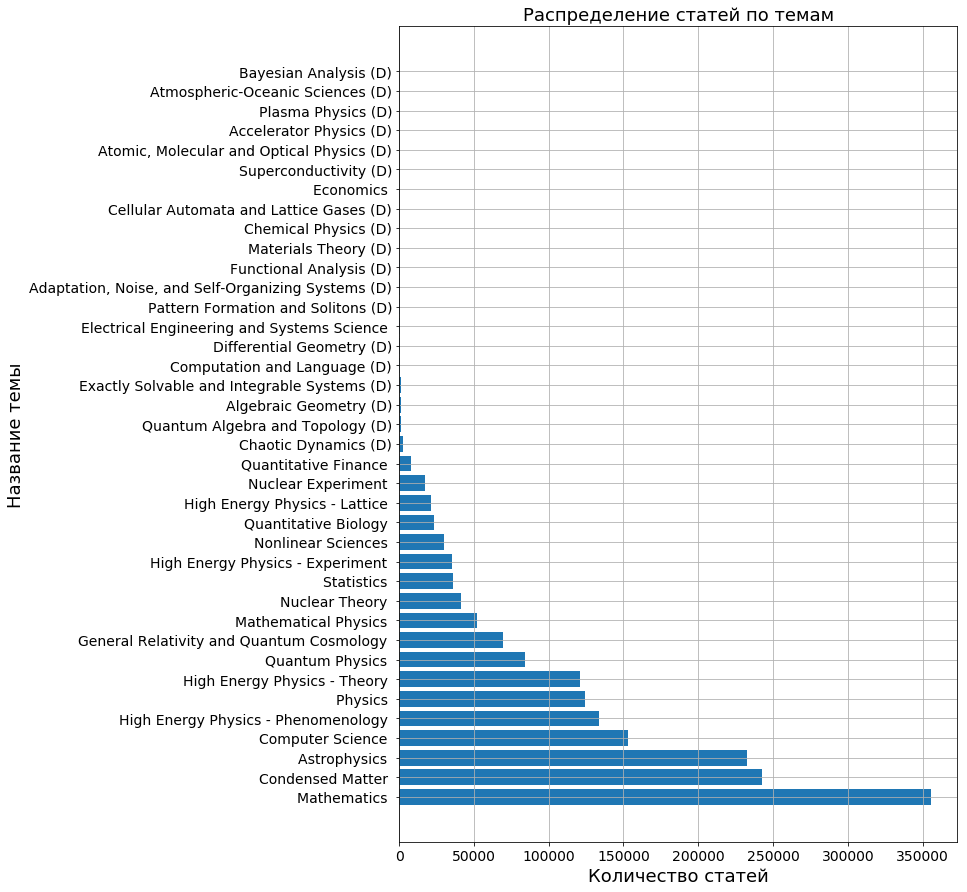

In [97]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
names = [repl_actuals[name] if name in repl_actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.ylabel('Название темы', fontsize=18)
plt.xlabel('Количество статей', fontsize=18)
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)

del count_themes
del items
del names
del pos
del h

Как видим, существует большое количество типов вершин (тегов или тем), которых крайне мало в обучающей выборке. Как оказалось, этому есть объяснение. Большинство из них являются устаревишми, а две из таких малочисленных категорий оказались новыми. Подробнее об этом можно узнать [тут](https://arxiv.org/archive/). На графике (D) -- deprecated

Теперь сделаем замену: старые группы на новые.

In [98]:
replace_tags(docs)

Ещё раз построим уже модифицированную гистограмму:

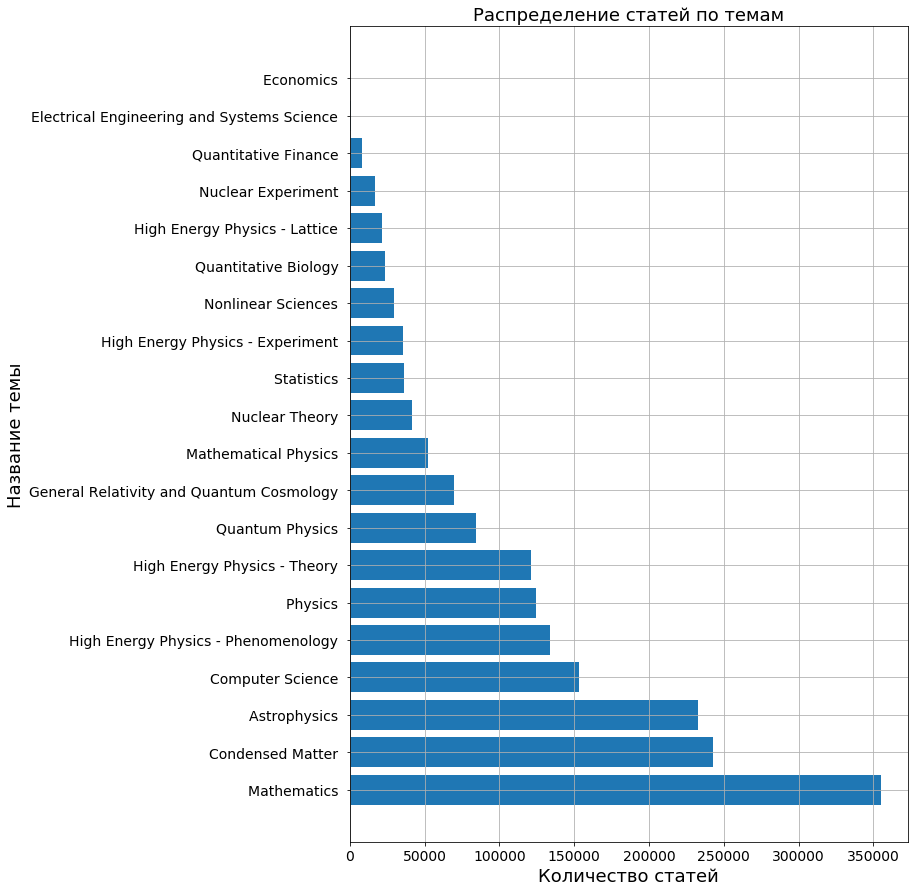

In [99]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.barh(pos, h)
plt.ylabel('Название темы', fontsize=18)
plt.xlabel('Количество статей', fontsize=18)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)

del count_themes
del items
del names
del pos
del h

Как мы говорили, вы выборке есть новые теги (Данные у нас есть до января 2018 года), а два тега: *Economics* и *Electrical Engineering and Systems Science* появились в сентябре 2017 года. Давайте исключим их, чтобы не портить общую картину.

In [ ]:
remove_noise_tags(docs)

Построим гистограмму без них

In [10]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True);

del count_themes
del items
del names
del pos
del h

### Характеристики графа

Давайте теперь займёмся графом. Построим его

In [56]:
del docs

In [3]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:21<00:00,  1.84s/it]


In [4]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

Давайте выделим компоненты связности и посмотрим на их размеры. Прим этом, как легко догадаться, в графе есть гигантская компонента, которую мы исключим. Она включает в себя $76\%$ вершин

In [60]:
cc = list(nx.connected_components(G))

In [61]:
print('Процент вершин в гигантской компоненте связности:', 1 - len(sorted([len(i) for i in cc])[::-1]) / len(docs))

Процент вершин в гигантской компоненте связности: 0.7611042505472944


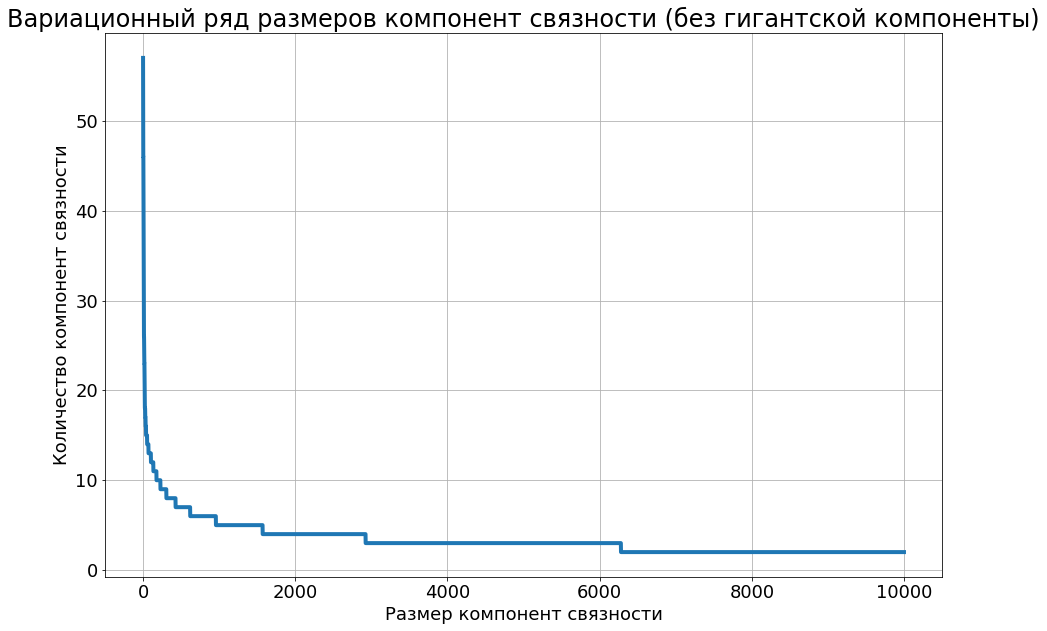

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i) for i in cc])[::-1][1:10000], linewidth=4)
plt.title('Вариационный ряд размеров компонент связности (без гигантской компоненты)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Размер компонент связности', fontsize=18)
plt.ylabel('Количество компонент связности', fontsize=18)
plt.grid(True);

Как видим, существуют достаточно большие компоненты связности (до 50 статей), которые не связаны с гиганской компонентой. Исследуем этот вопрос. Есть гипотеза, которая связана связанна с тем, что есть кластеры образуются вокруг определённых авторов, которые занимаются той или иной темой


### Кластеры размером более 4 статей

Взглянем на несколько из кластеров и на авторов, которые писали статьи:

In [63]:
clusters = sorted([i for i in cc], key=lambda el: len(el))[::-1]

In [78]:
def plot_clusters(cluster_num, max_authors=20, show_authors=True):
    authors = []
    for name in clusters[cluster_num]:
        authors += docs[name][ArxivTags.Authors]

    items = sorted(Counter(authors).items(), key=lambda el: el[1])[::-1][:max_authors]
    h = [item[1] for item in items]
    names = [item[0] for item in items]
    plt.plot(h, 'r-', linewidth=3)
    plt.yticks(fontsize=18)
    if show_authors:
        plt.xticks(list(range(len(names))), names, rotation=60, fontsize=18)
        plt.xlabel('Имя автора', fontsize=18)
    plt.ylabel('Количество упоминаний', fontsize=18)
    plt.title('Число статей, в которых человек является соавтором в отдельном кластере', fontsize=18)
    plt.grid(True)

In [79]:
plt.figure(figsize=(15,10))
plot_clusters(1)

In [80]:
plt.figure(figsize=(15,10))
plot_clusters(2)

Теперь давайте выведем больше графиков

In [81]:
plt.figure(figsize=(15,10))
for i in range(1, 10):
    plot_clusters(i, show_authors=False)
    
plt.figure(figsize=(15,10))
for i in range(10, 20):
    plot_clusters(i, show_authors=False)
    
plt.figure(figsize=(15,10))
for i in range(20, 30):
    plot_clusters(i, show_authors=False)

Ага, интересно... мы видим, что есть существенная доля авторов, которые во многих статьях являются соавторами. Будем называть человека, который чаще других (в рамках конкретного кластера) пишет статьи, **идеологом**. Процент статей, в которых идеолог являлся автором (соавтором), будем называть **идеологическими**. Давайте посмотрим на гистограмму идеологических статей в мелких (не гигантской компоненте) кластерах.

In [203]:
def plot_ideological_hist(t, bins):
    ideological = []
    count_papers = []
    for cluster in clusters[1:]:
        authors = []
        count = 0
        if len(cluster) < t:
            continue
        for name in cluster:
            authors += docs[name][ArxivTags.Authors]
            count += 1
        ideological.append([item[1] for item in Counter(authors).items()])
        count_papers.append(count)

    ideologs = []
    for n, p in zip(count_papers, ideological):
        ideologs.append(max(p) / n)

    plt.figure(figsize=(15, 10))
    plt.hist(ideologs, bins=bins)
    plt.ylabel('Количество кластеров', fontsize=18)
    plt.xlabel('Доля идеологических статей в кластере размера не менее %d' % t, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)

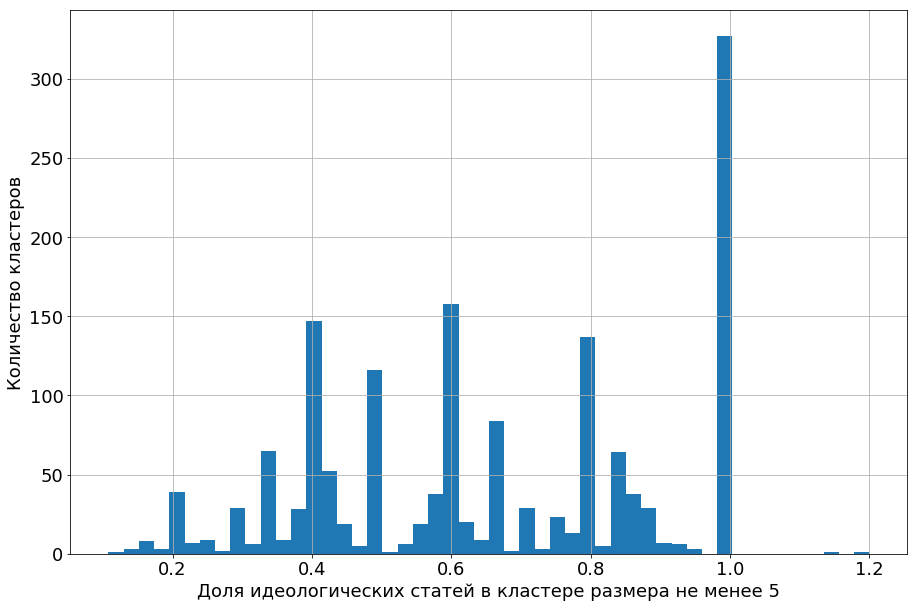

In [204]:
plot_ideological_hist(5, 50)

Первое, что бросается в глаза -- это пик в точке 1. Он легко может быть объяснён. Существует много авторов, которые участвовали в написании каждой статьи кластера.

Ещё один аспект, который также кажется странным -- это то, что есть значения более 1. Это легко объяснить. В ряде кластеров, есть авторы, у которых одинаковые инициалы и фамилии. Скорее всего это родственники. Вероятнее всего, китайцы.

Исследуем явные пики в нескольких точках, помимо 1. Они явно выделяются. Для этого, прежде всего построим несколько гистограмм помельче.

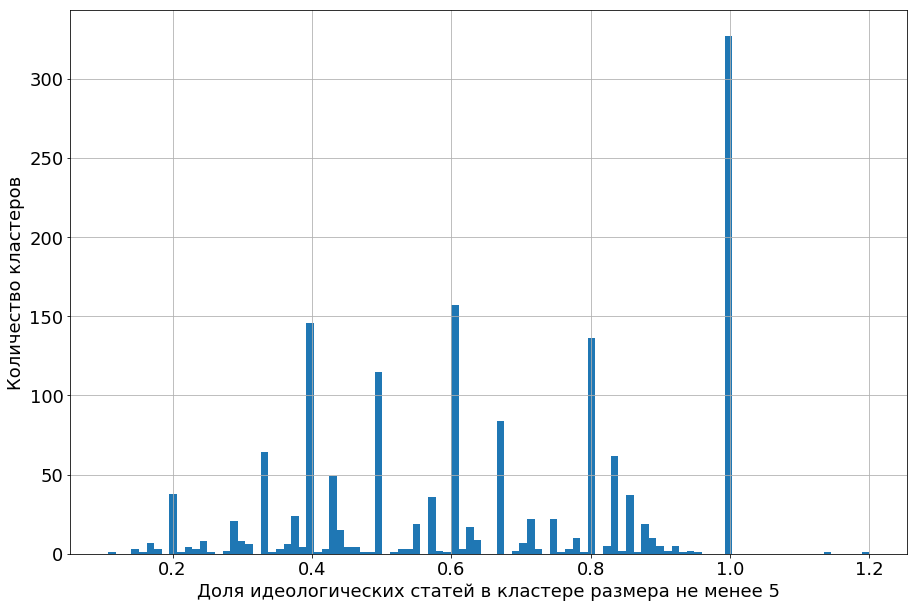

In [239]:
plot_ideological_hist(5, 100)

Как легко заметить, выделяются явные пики в точках 0.2, 0.4, 0.5, 0.6, 0.8. Для того, чтобы ответить на вопрос о причинах такого поведения гистограммы, давайте представим 0.2, 0.4, 0.6, 0.8, 0.5 в виде дробей: $\dfrac{1}{5}, \dfrac{2}{5}, \dfrac{3}{5}, \dfrac{4}{5}, \dfrac{1}{2}$. В результате, пики в дробях с 5 в знаменателе, легко объяснимы. Они означают, что $n$ из $m$ статей писал идеолог, где $n$, $m$ -- части дроби вида $\dfrac{n}{m}$. Отметим указанные точки, соответствующие указанным дробям на графике, чтобы продемонстрировать закономерность.

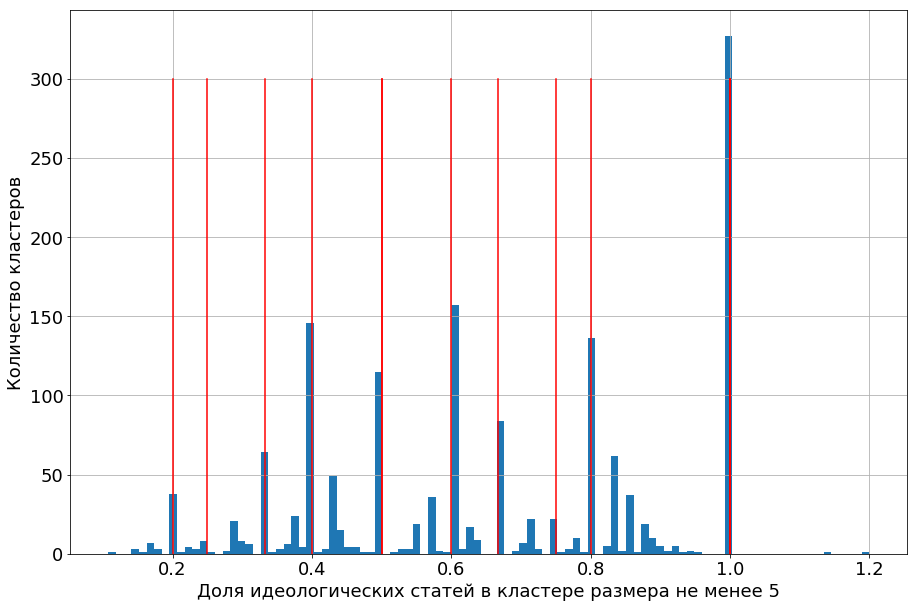

In [240]:
plot_ideological_hist(5, 100)
m = 300
for denumerator in range(1, 6):
    for numerator in range(1, denumerator + 1):
        p = numerator / float(denumerator)
        plt.plot([p, p], [0, m], 'r-')

Давайте построим гистограмму для кластеров размера не менее 6. Как видим, кластера кратные 5 исчезли. Этот факт подтверждает нашу гипотезу.

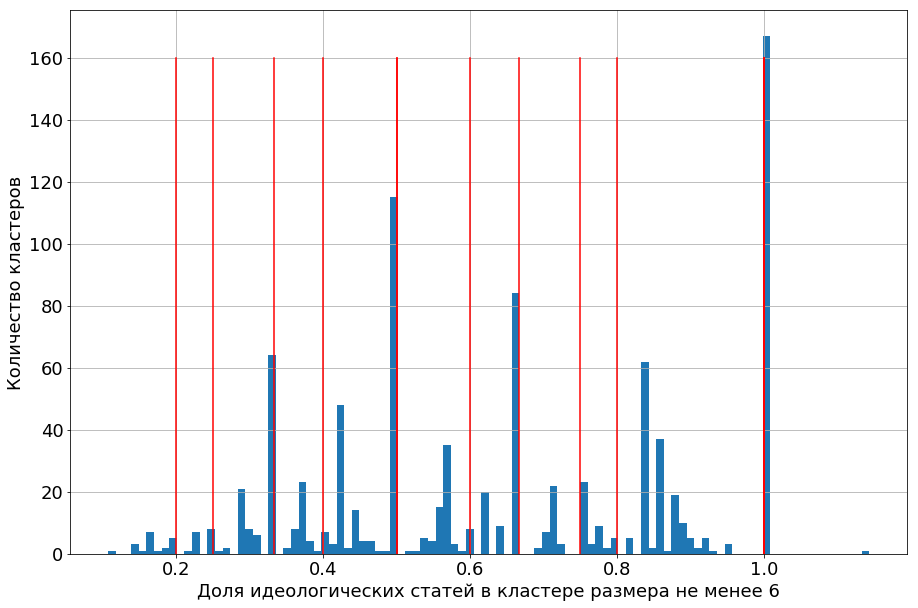

In [206]:
plot_ideological_hist(6, 100)
m = 160
for denumerator in range(1, 6):
    for numerator in range(1, denumerator + 1):
        p = numerator / float(denumerator)
        plt.plot([p, p], [0, m], 'r-')

Выберем все те кластера, в которых идеологи особо отличаются: пишут все статьи (точка 1).

In [207]:
ideological = []
t = 5
i = 0
for cluster in clusters[1:]:
    authors = []
    count = 0
    if len(cluster) < t:
        continue
    for name in cluster:
        authors += docs[name][ArxivTags.Authors]
        count += 1
    
    items = [item[1] for item in Counter(authors).items()]
    authors = [item[0] for item in Counter(authors).items()]
    argmax = np.argmax(items)
    if items[argmax] >= count:
        print(i + 1, authors[argmax], cluster)
        i += 1

1 W.-K.Park {'1207.0582', '1601.01915', '1601.01916', '1208.0641', '1304.3223', '1704.03582', '1409.1754', '1208.2063', '1308.3906', '1308.3905', '1208.5203', '1601.01911', '1707.03643', '1601.01914', '1207.0586', '1306.0265', '1404.2378', '1704.03583'}
2 C.D.Charalambous {'1701.01007', '1310.3085', '1302.3971', '1104.0862', '1604.01056', '1512.04514', '1210.1266', '1301.6520', '1604.02742', '1401.5828', '1210.2019', '1301.6522', '1304.6528', '1212.6643', '1604.01063', '1405.1593', '1204.2980'}
3 V.N.Soshnikov {'physics/9706041', '0801.0286', 'physics/0105040', 'physics/0111014', '0711.2782', 'physics/0612064', 'physics/0610220', '0708.0767', 'physics/0205035', 'physics/0208098', 'physics/9712013', '0708.0748', '0709.2206', 'plasm-ph/9511001', '0711.1321'}
4 V.Kurasov {'cond-mat/0412141', '0808.2999', 'cond-mat/9310005', '1302.5064', '0801.0239', 'cond-mat/0505738', 'cond-mat/0410616', '0901.3437', 'cond-mat/0410774', '1301.1915', '0711.4559', '0801.0242', '1011.3543', 'cond-mat/060776

Для детального анализа кластеров, я буду брать первую статью из кластера и проводить её поверхностный анализ. Если она мне будет казаться подозрительной, то я буду брать ещё несколько.

### Рассмотрим НЕ "подозрительные" кластеры:

Рассмотрим 1 кластер. Его образует идеолог Won-Kwang Park. В ссылках часто фигугирует H. Ammari:

* https://arxiv.org/pdf/1207.0586.pdf

* https://arxiv.org/pdf/1707.03643.pdf

* https://arxiv.org/pdf/1601.01916.pdf

Статьи кажутся вполне вменяемыми. Кроме того, они ссылаются на различные источники, которые не фигурируют на arxiv.

_________________

Рассмотрим 2 кластер. Идеолог в данном кластере является Charalambos D. Charalambous

* https://arxiv.org/pdf/1701.01007.pdf
* https://arxiv.org/pdf/1310.3085.pdf
* https://arxiv.org/pdf/1302.3971.pdf

Статьи кажутся вполне вменяемыми. Кроме того, они ссылаются на различные источники, которые не фигурируют на arxiv.
_________________

Рассмотрим 3 кластер. Идеолог в данном кластере является Сошников.

https://arxiv.org/pdf/physics/9706041.pdf

Статьи кажутся вполне вменяемыми. Кроме того, они ссылаются на различные источники, которые не фигурируют на arxiv.

### Рассмотрим *подозрительные* кластеры:
_________________

Приведём пример *подозрительного* 6го кластера. 

* https://arxiv.org/pdf/quant-ph/0411060.pdf
* https://arxiv.org/pdf/quant-ph/0506074.pdf
* https://arxiv.org/pdf/quant-ph/9906043.pdf
* https://arxiv.org/pdf/quant-ph/0503059.pdf
* https://arxiv.org/pdf/quant-ph/0411060.pdf

Идеолог: https://www.researchgate.net/profile/Habatwa_Mweene

Идеолог данных работ ссылается, в подавляющем большинстве случаев только на 1 автора. Немного смущает, что этот человек из Замбии. Я не расист, но всё-таки.

_________________

Ещё один *подозрительный* 7ый кластер. Идеолог рассуждает о странных исторических объектах, а также иногда ссылается на википедию, как на достоверный источник

* https://arxiv.org/pdf/1107.5831.pdf
* https://arxiv.org/pdf/1204.6497.pdf
* https://arxiv.org/pdf/1205.0706.pdf

Идеолог: A.C.Sparavigna
_________________

Ещё один *подозрительный* 10ый кластер. Идеолог рассуждает о Фурье и функциях комплексного аргумента. Есть ссылки на вики и очень много ссылок на свои же статьи. Это настораживает.

* https://arxiv.org/pdf/1409.2582.pdf
* https://arxiv.org/pdf/1710.10947.pdf
* https://arxiv.org/pdf/1708.07017.pdf

Идеолог: Jorge L.deLyra


_________________

13ый кластер. Идеолог говорит о [новом принципе в физике](https://arxiv.org/pdf/0812.4343.pdf). В ряде статейесть ссылки только на свои статьи. Вызывает сомнения, что автор ссылается на очень древние работы (1946, 1935 года). Если же работы не его, то часто это могут быть монографии и значимой ссылкой это вряд ли может быть.

* https://arxiv.org/pdf/0812.4343.pdf
* https://arxiv.org/pdf/physics/0312043.pdf
* https://arxiv.org/pdf/cond-mat/0412396.pdf
* https://arxiv.org/pdf/0904.2911.pdf
* https://arxiv.org/pdf/physics/0006038.pdf

Идеолог: C.Y.Chen


_________________

14ый кластер. Работа по социологии. Крайне много ссылок в каждой статье. Человек публикует 3-4 статьи в год. При этом делает это в одиночку. Это настораживает.

* https://arxiv.org/pdf/1601.01222.pdf
* https://arxiv.org/pdf/1411.0092.pdf
* https://arxiv.org/pdf/1508.01869.pdf
* https://arxiv.org/pdf/1506.01821.pdf
* https://arxiv.org/pdf/physics/0006038.pdf

Идеолог: V.D.Florio


_________________

21ый кластер. Человек публикуется в одиночку, при этом, за год успевает сделать 3-4 работы. Но в работах присутствуют ссылки на работы других людей (не arxiv). 

* https://arxiv.org/pdf/1007.5434.pdf
* https://arxiv.org/pdf/0912.5091.pdf
* https://arxiv.org/pdf/1002.1414.pdf

Идеолог: D.Z.Djokovic

### Выводы

Таким образом, я проанализировал 50 первых кластеров из 329. Из них всего 6 оказались, действительно, с особенностями. Остальные же не представляли собой интерес с этой точки зрения. Я заострил внимание на том, что люди могут публиковать много статей за год, действуя в одиночку. В нескольких случаях люди исследовали очень странные вещи, а также ссылались либо только на свои статьи, либо на свои статьи, монографии и древние работы (например, 1936 года). 

В связи с этим, можно заключить, что малые кластеры (те, в которых более 4 статей) образованы, как правило, в связи с тем, что статьи ссылаются на внешние источники (не arxiv), либо же из-за того, что ссылки на статьи arxiv не были распознаны (авторы датасета в личной переписке сказали, что ссылки статей друг на друга формировались на основе эвристик, задаваемых регулярными выражениями).

Кластеры, в которых оказываются 4 и менее статьи, могли образоваться по тем же причинам, либо же, образоваться из-за того, что 

### Кластеры менее чем из 5 статей

In [236]:
print('Число кластеров из 1 статьи:', len([1 for c in clusters if len(c) == 1]))
print('Число кластеров из 1 статьи:', len([1 for c in clusters if len(c) == 1]) / len(docs))
print('Всего кластеров менее чем из 5 статей:', len([1 for c in clusters if len(c) < 5]))

Число кластеров из 1 статьи: 302293
Число кластеров из 1 статьи: 0.2250163202019909
Всего кластеров менее чем из 5 статей: 319367


Таким образом, почти все мелкие кластеры образованы отдельными статьями. Число таких статей равно $22,5\%$. Это довольно много. Причин образования единичных кластеров может быть несколько. Наиболее вероятные из них:

* Автор написал единственную статью когда-то в прошлом
* Автор написал единственную статью и ещё не успел написать других статей
* Автор написал много статей, но мало публиковал на arxiv (т.е. есть ссылки на внешние источники)
* Погрешность при составлении датасета
* Агрегация всех вышеперечисленных причин

Помимо единичных кластеров, есть кластеры, образованные 2-4 статьями. Давайте попробуем понять, почему возникают такие объекты. Для этого посмотрим, разницу между первой публикацией в рамках кластера и последней. Построим гистограмму для этой характеристики:

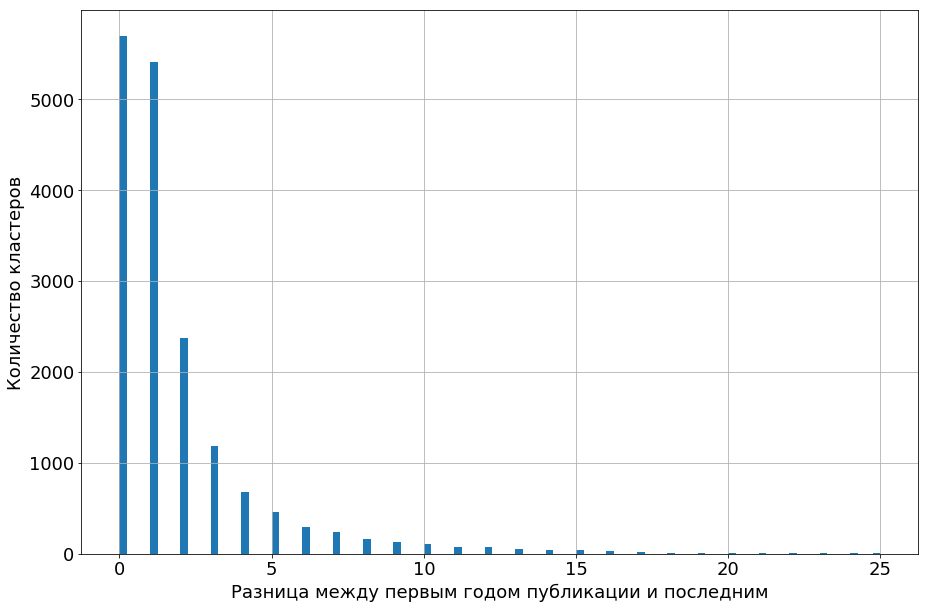

In [242]:
years_all = []
c = []
t = 5
i = 0
for cluster in clusters[1:]:
    years = []
    count = 0
    if len(cluster) >= t or len(cluster) < 2:
        continue
    for name in cluster:
        years.append(docs[name][ArxivTags.Year])
    years_all.append((max(years) - min(years)))
    if (max(years) - min(years)) != 0:
        c.append(cluster)
        
plt.figure(figsize=(15, 10))
plt.hist(years_all, bins=100)
plt.ylabel('Количество кластеров', fontsize=18)
plt.xlabel('Разница между первым годом публикации и последним', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

Таким образом, видим, что добрая половина всех кластеров, состоящих из 2-4 статей содержат в себе статьи, которые были опубликованы в один год, либо же в 2 года подряд. Это косвенно указывает на то, что:

* Автор написали несколько статьей когда-то в прошлом и больше не пишут статьи по данной теме
* Авторы написали несколько статьей и ещё не успели написать других статей

Нельзя также исключать и других причин:

* Автор написал много статей, но мало публиковал на arxiv (т.е. есть ссылки на внешние источники)
* Погрешность при составлении датасета

Но они менее вероятны.

# Раздел 2. Рассчёт различных характеристик графа

Прежде чем идти дальше, оговоримся, нас будет интересовать, как меняется та или иная характеристика с ростом числа вершин. При этом, увеличивать число вершин будем двумя способами:

1. Случайно выбираем подграф размера $n$
2. Отсортируем все вершины в порядке их появления в графе. Будем выбирать первые $n$ вершин

Всюду ниже, если не оговаривается обратного, строим ориентированный граф. Также будем строить ориентированный граф гигантской компоненты связности, ибо именно она представляет основной интересно. Все же более мелкие компоненты будут лишь усложнять анализ, а также менее представительны и, как мы выяснили выше, скорее всего являются особенностью данных и представляют небольшой интерес. Для чистоты эксперимента, также уберём мелкие категории *eess, econ*, поскольку они не информативны.

Первый способ необходим для понимания того, как граф ведёт себя в стационарном состоянии, а значит, как будет вести себя при масштабировании. Второй способ позволит анализировать эволюцию графа.

Рассмотрим первый способ.

*Замечание*: большинство из выдвинутых гипотез относительно интерпретаций структур графа, являются лишь фантазией автора и требуют детального исследования текстов работ, что данный датасет не позволяет сделать. Эти гипотезы подтверждают лишь дедуктивные рассуждения и некоторые характеристики, которые мы измерим для графа. Это тема для отдельной работы. При этом, структурные свойства, которыми обладает граф, будут проверены и их можно воспринимать как достоверные.

### Паттерны в графах. Число треугольников

Как легко понять, треугольники в неориентированном графе нас мало интересуют, так как ссылочный граф представляет интерес в том случае, когда есть соответствие $A \rightarrow B$ (ссылается). Более того, $B$, как правило ничего не знает про $A$, поэтому для связи $A \rightarrow B$ обратная связь не имеет смысла.

Но ради интереса, давайте понаблюдаем, как меняется число треугольников в зависимости от числа вершин. Для того, чтобы не подсчитывать число треугольников в полном графе, будем рассчитывать их количество для $10 \%$ вершин. Будем это делать так:

1. Выберем случайный подграф размера $n$
2. Выберем случайную вершину $v_0$ этого подграфа
3. Переберём всех соседей $v_1$ вершины $v_0$
4. Для каждой вершины $v_1$ переберём всех её соседей $v_2$.
5. Посчитаем, сколько троек $(v_0, v_1, v_2)$ образуют треугольник (т.е. имеют связи)

Будем выполнять пункты 2-5 для $10\%$ (в ряде случаев изменим долю рассматриваемых вершин) вершин без повторений вершин. После чего посчитаем суммарное число троек. Аналогичный алгоритм будем применять для подсчёта других характеристик. Мы не будем брать все тройки, чтобы ускорить рассчёты. Разумеется, число треугольников мы будем подсчитывать для неориентированного графа.

In [5]:
del docs
del G

In [2]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:21<00:00,  1.81s/it]


In [3]:
remove_noise_tags(docs)

In [4]:
G = nx.Graph()
for doc in tqdm_notebook(docs, desc='Построение графа'):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

In [16]:
def custom_plot(x, y, title, ylabel, text, xlabel='Число вершин', font=18, title_font=24, linewidth=4, markersize=10):
    plt.plot(x, y, 'b-', linewidth=linewidth)
    plt.plot(x, y, 'ro', markersize=markersize)
    plt.title(title, fontsize=title_font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel(xlabel, fontsize=font)
    plt.ylabel(ylabel, fontsize=font)
    plt.text(x[-1], y[-1], text, fontsize=font)
    plt.grid(True)
    
def count_metric(G, metric, desc, proporion, sizes_subgraph, is_save_objs=False, random_state=42):
    all_objs = []
    vertexes = list(G.nodes)
    np.random.seed(random_state)
    for n in tqdm_notebook(sizes_subgraph, desc=desc):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = list(np.array(vertexes)[perm])[:n]
        subgraph = G.subgraph(random_vertex)
        objs = []
        for v in random_vertex[:int(n * proporion)]:
            objs += metric(subgraph, v)
        if is_save_objs:
            all_objs.append(list(set(objs)))
        else:
            all_objs.append(len(set(objs)))
    return all_objs

In [6]:
def get_triangle(g, v0):
    vertexes = []
    for v1 in G.neighbors(v0):
        for v2 in G.neighbors(v1):
            if v2 == v0:
                vertexes.append('~'.join(sorted((v0, v1, v2))))
    return vertexes

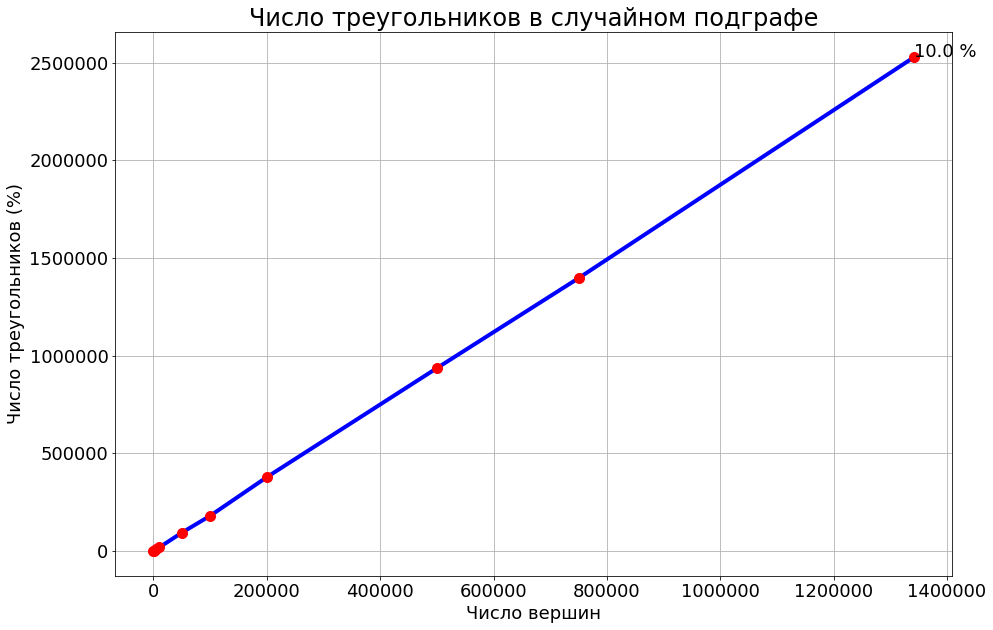

In [7]:
proportion = 0.1
sizes_subgraph = [5, 100, 5000, 10000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
count_K3 = count_metric(G, get_triangle, 'Подсчёт числа треугольников', proportion, sizes_subgraph)

plt.figure(figsize=(15, 10))
custom_plot(
    sizes_subgraph, count_K3,
    'Число треугольников в случайном подграфе',
    'Число треугольников (%)',
    str(proportion * 100) + ' %'
)

Легко можно подсчитать число треугольников для полного графа составлением простого отношения. Их, очевидно, будет в 10 раз больше.

In [8]:
del count_K3
del sizes_subgraph

Число треугольников растёт линейно в зависимости от числа вершин. Этот важный факт означает, что эта характеристика не изменяется в среднем для различных подмножеств графа одинакового размера и "плотность" треугольников в любой области графа одинаковая.

Куда интереснее другие характеристики.

### Диполи

Начнём с диполей, т.е. двух вершин, которые ссылаются друг на друга. Что это может означать? Одной из возможных интерпретаций такой структуры, является **повышение индекса цитирования**. Или, иными словами, это можно расценивать как мошеннические действия со стороны авторов. Другим вариантом является укрепление аргументации в свою пользу, что, на самом деле, тоже можно расценить как вариант мошенничества. Детальнее можно почитать [здесь](http://blogs.discovermagazine.com/neuroskeptic/2014/10/12/what-drives-academic-citations/#.XAcS38szY5k), [здесь](https://www.researchgate.net/publication/260600655_A_taxonomy_of_motives_to_cite) и [здесь](https://writing-skills-development.blogspot.com/2015/11/dlja-chego-uchenye-ssylajutsja-drug-na-druga.html). Если копнуть глубже, то такие ситуации (да, и вообще, ситуации с циклами) кажутся крайне странными: по сути мы имеем ссылку в будущее. То есть автор ссылается ещё на неопубликованную статью. 

Покажем это для $n$ вершин. Пусть у нас есть последовательность вершин: $v_0, v_1, v_2, v_3 \cdots v_{n-1}$, которые образуют цикл. Каждая вершина имеет метку, связанную с датой выхода работы. Будем идти по этим вершинам начиная с $v_0$ до тех пор, пока $t_i \leq t_{i+1}$. Но в какой-то момент, мы придём в исходную вершину, для которой уж точно не будет выполняться $t_{n-1} \leq t_0$ (возможно, это произойдёт раньше). ЧТД. Таким образом, это выполняется и для $n=2$.

Кажется, что если такие статьи существуют, то они должны находиться рядом друг от друга во времени.

Третьим объяснением может являться, опять же, принцип обработки датасета: ошибки в построении ребёр и графа. 

Вершины, которые входят в диполь, будем называть $F_2$ (от англ. fraud).

In [9]:
del G

In [10]:
G = nx.DiGraph()
for doc in tqdm_notebook(docs, desc='Построение графа (ориентированный)'):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

In [11]:
def get_dipole(g, v0):
    vertexes = []
    for v1 in G.neighbors(v0):
        if v0 in G.neighbors(v1):
            vertexes.append('~'.join(sorted((v0, v1))))
    return vertexes

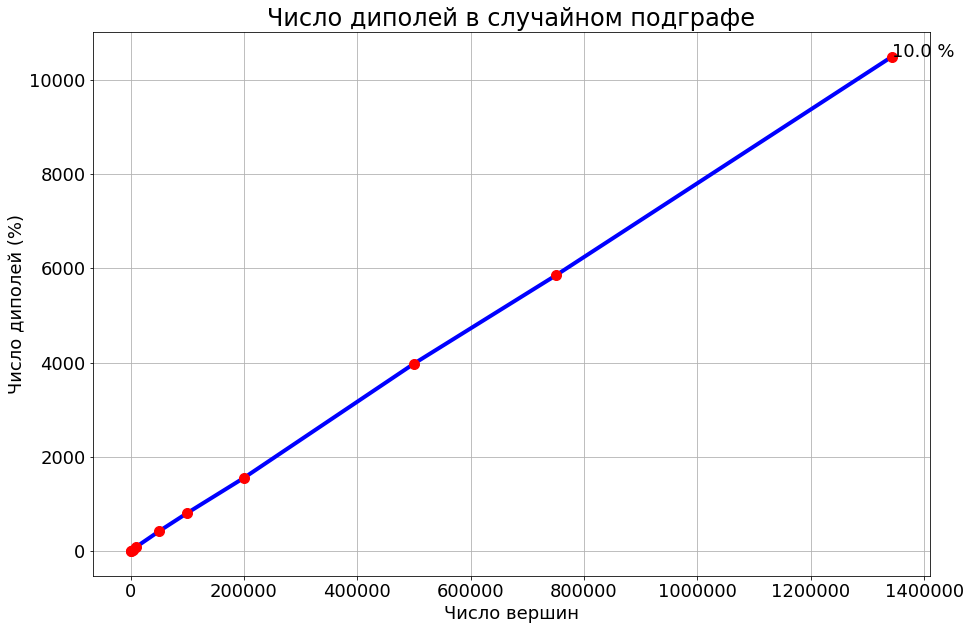

In [18]:
proportion = 0.1
sizes_subgraph = [5, 100, 5000, 10000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
count_direction_K2 = count_metric(G, get_dipole, 'Число диполей', proportion, sizes_subgraph)

plt.figure(figsize=(15, 10))
custom_plot(
    sizes_subgraph, count_direction_K2,
    'Число диполей в случайном подграфе',
    'Число диполей (%)',
    str(proportion * 100) + ' %'
)

Видим линейную зависимость от числа вершин. Т.е. при разростании графа число мошенников увеличивается. При этом, важно, увеличение размеров графа никак не влияет на появление бо'льшего количества мошенников. Например, гипотетически, можно было бы предположить, что рост графа способствует появлению дополнительных связей (дополнительных диполей), тем самым увеличивая число мошеннических статей. Но этого, как мы видим, не происходит, что, в принципе, закономерно. Другое дело, требуется исследовать вопрос роста мошеннических связей во времени, т.е. при добавлении вершин в хронологическом порядке. Этот аспект мы будем исследовать ниже.

Считая, что число диполей для полного графа будет в 10 раз больше, легко понять, число рёбер, которые входят в диполи, будет ещё в 2 раза больше. Тогда окажется, что почти $2\%$ ребер входят в диполи:

In [19]:
print('Число ребёр в диполях полного графа: %f' % (2. * count_direction_K2[-1] * 10 / len(G.edges)))

Число ребёр в диполях полного графа: 0.016532


Кажется, что это довольно много для погрешности при обработке графа. Обработаем весь граф и вытащим всех авторов, у которых есть такие статьи.

In [20]:
del count_direction_K2
del sizes_subgraph

In [66]:
proportion = 1
sizes_subgraph = [len(G.nodes)]
vertexes = count_metric(G, get_dipole, 'Собираем информацию о всех вершинах', proportion, sizes_subgraph, True)

Давайте теперь посмотрим, как же устроено распределение авторов, которые творили такие дела. Легко догадаться, как оно будет выглядеть:

In [94]:
authors = []
for doc in vertexes[0]:
    doc0 = doc.split('~')[0]
    doc1 = doc.split('~')[1]
    authors += docs[doc0][ArxivTags.Authors]
    authors += docs[doc1][ArxivTags.Authors]

authors = Counter(authors)
counts = []
for key in authors:
    counts.append(authors[key])

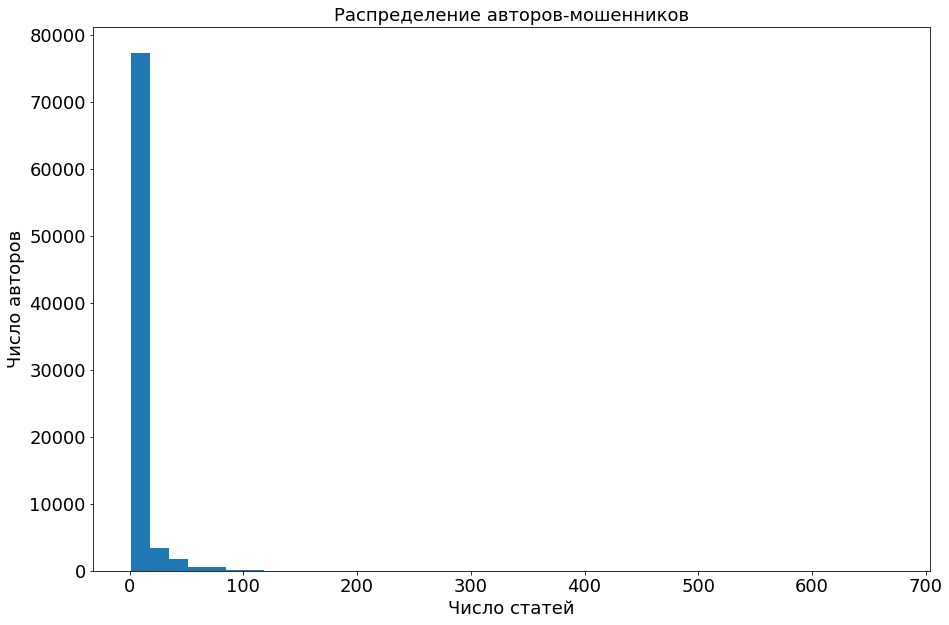

In [69]:
plt.figure(figsize=(15, 10))
plt.hist(counts, bins=40)
plt.xlabel('Число статей', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение авторов-мошенников', fontsize=18);

Очевидно, что есть большое количество авторов, которые делали так небольшое количество раз (либо же, ссылка была неверно сформирована в процессе построения датасета). Все они, с большой долей вероятности находятся в спайке около нуля. Плюс, возможно, в этот же спайк входят те, кто поступал так однократно или небольшое число раз. Попробуем это проанализировать. Для начала, взглянем на распределение пристальнее:

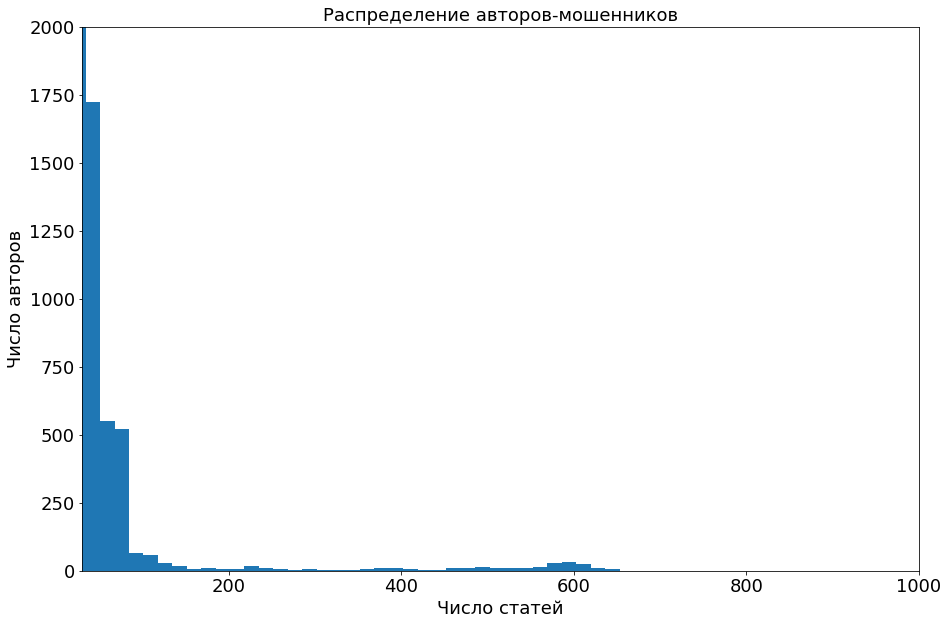

In [81]:
plt.figure(figsize=(15, 10))
plt.hist(counts, bins=40)
plt.xlabel('Число статей', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение авторов-мошенников', fontsize=18)
plt.xlim([30, 1000])
plt.ylim([0, 2000]);

Относительно большое количество авторов присутствует в хвосте распределения. У некоторых из них более 600 статей!!! 600, Карл!!! И это только те, которые входят в диполи. Давайте ещё помельче нарежем гистограмму и взглянем на неё. 

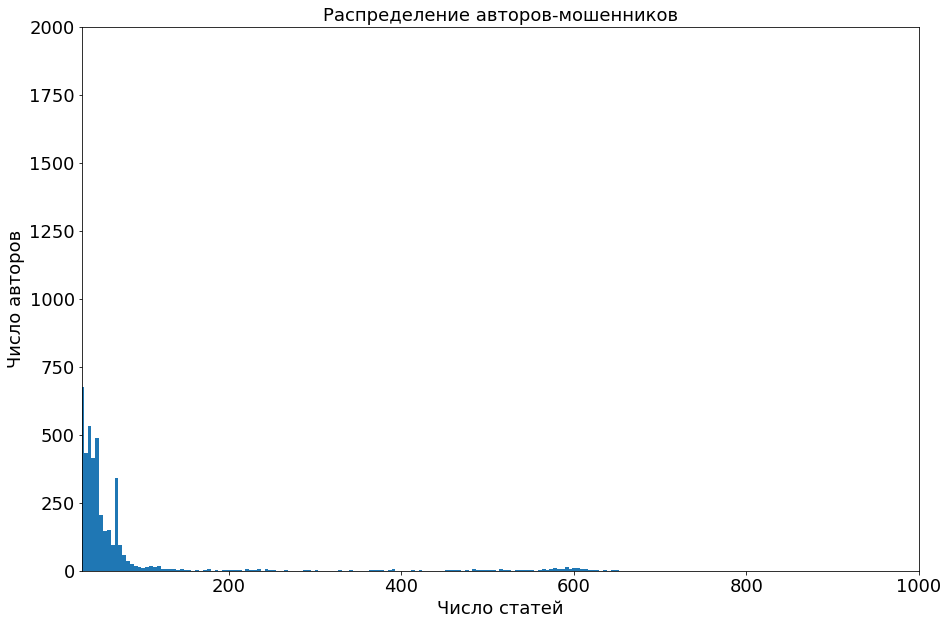

In [93]:
plt.figure(figsize=(15, 10))
plt.hist(counts, bins=150)
plt.xlabel('Число статей', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение авторов-мошенников', fontsize=18)
plt.xlim([30, 1000])
plt.ylim([0, 2000]);

Интересной особенностью является спайк у казалось бы, более или менее гладкого распределения в районе 70 статей. Этот вопрос следовало бы отдельно изучить.

Давайте возмём нескольких авторов и изучим их работы, входящие в диполи. Поступим так. Возьмём 20 любых авторов из отрезка [1; 5] статей. Возьмём 1 любого автора из отрезка [6; 30] статей. Возьмём 1 любого автора из отрезка [80; 120] статей. И ещё 1 из отрезка [550; 650] статей.

#### Отрезок [1;5]

In [119]:
count = 20
target_authors = []
print('Авторы:')
for k in authors:
    if authors[k] >= 1 and authors[k] <= 5 and count > 0:
        print(k)
        target_authors.append(k)
        count -= 1

Авторы:
M.Henze
J.-U.Ness
S.C.Williams
A.W.Shafter
K.Hornoch
V.Votruba
W.M.Wieland
J.Tambornino
X.Zambrana-Puyalto
N.Tischler
A.Minovich
X.Vidal
M.L.Juan
F.T.-H.Fong
G.Székelyhidi
Th.Zink
A.Mihatsch
A.G.Kosovichev
R.Bogart
T.L.D.Jr


Выведем все работы авторов

In [120]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
M.Henze 1401.2904 -> 1401.2905
M.Henze 1401.2905 -> 1401.2904
J.-U.Ness 1401.2904 -> 1401.2905
J.-U.Ness 1401.2905 -> 1401.2904
S.C.Williams 1401.2904 -> 1401.2905
S.C.Williams 1401.2905 -> 1401.2904
A.W.Shafter 1401.2904 -> 1401.2905
A.W.Shafter 1401.2905 -> 1401.2904
K.Hornoch 1401.2905 -> 1401.2904
V.Votruba 1401.2905 -> 1401.2904
W.M.Wieland 1107.5002 -> 1108.0369
J.Tambornino 1108.0369 -> 1107.5002
X.Zambrana-Puyalto 1206.0868 -> 1206.5563
X.Zambrana-Puyalto 1206.5563 -> 1206.0868
N.Tischler 1206.0868 -> 1206.5563
A.Minovich 1206.0868 -> 1206.5563
X.Vidal 1206.0868 -> 1206.5563
M.L.Juan 1206.0868 -> 1206.5563
F.T.-H.Fong 1104.3924 -> 1107.2144
G.Székelyhidi 1107.2144 -> 1104.3924
Th.Zink 1408.4071 -> 1611.06520
A.Mihatsch 1611.06520 -> 1408.4071
A.G.Kosovichev 1010.4927 -> 1011.0799
A.G.Kosovichev 1011.0799 -> 1010.4927
R.Bogart 1011.0799 -> 1010.4927
T.L.D.Jr 1011.0799 -> 1010.4927
G.Székelyhidi 1706.00357 -> 1705.

Рассмотрим статьи [1401.2904](https://arxiv.org/pdf/1401.2904.pdf) и [1401.2905](https://arxiv.org/pdf/1401.2905.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Названия статей практически одинаковые: 

* A remarkable recurrent nova in M 31 - The X-ray observations
* A remarkable recurrent nova in M31 - The optical observations

Я не силён в физике, но кажется, что статьи очень близки по содержанию и скорее всего изучают близкие явления. Более того, они были опубликованы друг за другом. При этом, это не умоляет того, что авторы допустили такой хак. Следует отметить, что обе статьи публиковала одна и та же группа учёных.

________________

Рассмотрим статьи [1401.2426](https://arxiv.org/pdf/1401.2426.pdf) и [1401.2905](https://arxiv.org/pdf/1401.2905.pdf) (та же статья, что и в предыдущем пункте). Ссылки в прошлое и будущее соответсвенно, есть. Здесь статьи были опубликованы в разное время. Скорее всего, они отстаят друг от друга на несколько дней. При этом, стоит принимать во внимание тот факт, что статьи могли публиковаться в каком-нибудь журнале одновременно. В связи с этим вышел такой коллапс. Но, опять же, это не уменьшает вины авторов.

В отличие от первых двух статей, здесь диполь образован двумя различными группами учёных. А значит, это люди, скорее всего, действовали в сговоре.

________________

Идём далее. Рассмотрим статьи [1107.5002](https://arxiv.org/pdf/1107.5002.pdf) и [1108.0369](https://arxiv.org/pdf/1108.0369.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Опять же, на лицо явный сговор авторов. Плюс к этому, стоит отметить, что статьи были опубликованы в разные месяцы. Та, что раньше опубликована 29 июля 2011. Та, что позже 1 августа 2011.

________________

Идём далее. Рассмотрим статьи [1107.5002](https://arxiv.org/pdf/1107.5002.pdf) и [1107.5274](https://arxiv.org/pdf/1107.5274.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Опять же, на лицо явный сговор авторов. Плюс к этому, стоит отметить, что статьи были опубликованы в разные месяцы. Та, что раньше опубликована 29 июля 2011. Та, что позже 1 августа 2011. Статью 1107.5274 написала та же группа авторов, что и 1108.0369. Опять же, налицо очевидный сговор двух групп авторов.

________________

До селе мы рассматривали только лишь статьи, которые отстоят друг от друга на несколько дней. Теперь же рассмотрим 2 статьи, разница между которыми больше года. [1611.06520](https://arxiv.org/pdf/1611.06520.pdf) и [1408.4071](https://arxiv.org/pdf/1408.4071.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Данную особенность тяжело объяснить. Как возникают такие ссылки не до конца понятно. Возможно, это связано с тем, что статьи прежде публикуются в журналах, а лишь потом выкладываются на arxiv. Т.е. статья 1611.06520 на самом деле -- это статья 2014 года, также как и статья 1408.4071. В таком случае это становится объяснимым. Но беглые поиски в гугле не принесли результатов. Аналогичную статью от 2014 года найти не удалось. Так что этот вопрос остаётся открытым.

Как видим, все ссылки построены верно (из тех работ, что мы рассматривали). Авторы, действительно, ссылаются друг на друга в прошлое и будушее. Причин этого эффекта до конца не ясны. Опустим анализ оставшихся работ, поскольку, они скорее всего выглядят похожим образом.

#### Отрезок [6;30]

In [123]:
count = 5
target_authors = []
print('Авторы:')
for k in authors:
    if authors[k] >= 6 and authors[k] <= 30 and count > 0:
        print(k)
        target_authors.append(k)
        count -= 1

Авторы:
M.J.Darnley
M.F.Bode
M.Kato
I.Hachisu
E.R.Livine


Выведем все работы авторов:

In [124]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
M.J.Darnley 1401.2904 -> 1401.2905
M.J.Darnley 1401.2905 -> 1401.2904
M.F.Bode 1401.2904 -> 1401.2905
M.F.Bode 1401.2905 -> 1401.2904
M.Kato 1401.2904 -> 1401.2905
I.Hachisu 1401.2904 -> 1401.2905
E.R.Livine 1108.0369 -> 1107.5002
E.R.Livine 0705.0674 -> 0705.2388
M.Kato 1511.01608 -> 1702.03074
E.R.Livine 1207.0416 -> 1303.6772
E.R.Livine 1103.3415 -> 1108.1569
E.R.Livine 1207.0416 -> 1211.2618
M.J.Darnley 1602.08492 -> 1602.03868
M.F.Bode 1602.08492 -> 1602.03868
M.J.Darnley 1602.08492 -> 1602.03920
M.F.Bode 1602.08492 -> 1602.03920
M.Kato 1106.3510 -> 1106.2027
I.Hachisu 1106.3510 -> 1106.2027
E.R.Livine 1107.5274 -> 1108.0369
E.R.Livine 1108.0369 -> 1107.5274
E.R.Livine 1504.02822 -> 1312.5646
M.Kato 1511.01608 -> 1604.04446
M.J.Darnley 1602.08492 -> 1604.04324
M.F.Bode 1602.08492 -> 1604.04324
M.Kato 1511.01608 -> 1612.03643
M.Kato 1106.3510 -> 1106.3071
I.Hachisu 1106.3510 -> 1106.3071
E.R.Livine 1107.5274 -> 1107.

Наблюдаем, что некоторые авторы работ 1401.2904, 1401.2905 (см. предыдущий пункт про отрезок [1; 5]): M.J.Darnley, M.F.Bode, M.Kato, I.Hachisu прибегают к ухищрениям чаще своих коллег. Для того, чтобы подтвердить, что и в этом подмножестве есть аналогичные связи, рассмотрим, например, работы:

[1111.2867](https://arxiv.org/pdf/1111.2867.pdf) и [1205.2019](https://arxiv.org/pdf/1205.2019.pdf). Ничего неожиданного. Авторы ссылают друг на друга. Как легко предположить, авторы ссылаются на статьи друг друга не только в указанных работах. Но и в других.

В связи с этим, возникает интересный вопрос: было бы замечательно научиться выделять группы авторов, который друг на друга ссылаются.

#### Отрезок [80;120]

Проделаем те же самые манипуляции

In [127]:
count = 1
target_authors = []
print('Авторы:')
for k in authors:
    if authors[k] >= 80 and authors[k] <= 120 and count > 0:
        print(k)
        target_authors.append(k)
        count -= 1

Авторы:
P.Carvalho


In [128]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
P.Carvalho 1303.5080 -> 1303.5082
P.Carvalho 1303.5088 -> 1303.5067
P.Carvalho 1101.2024 -> 1101.2025
P.Carvalho 1303.5080 -> 1303.5076
P.Carvalho 1502.01582 -> 1506.07135
P.Carvalho 1303.5080 -> 1303.5086
P.Carvalho 1507.02058 -> 1507.02058
P.Carvalho 1507.02058 -> 1507.02058
P.Carvalho 1502.01582 -> 1502.01589
P.Carvalho 1101.2041 -> 1101.2026
P.Carvalho 1303.5088 -> 1303.5065
P.Carvalho 1101.2024 -> 1101.2026
P.Carvalho 1507.02058 -> 1502.01593
P.Carvalho 1507.02058 -> 1506.07135
P.Carvalho 1502.01582 -> 1505.08022
P.Carvalho 1303.5088 -> 1303.5074
P.Carvalho 1303.5089 -> 1303.5063
P.Carvalho 1507.02058 -> 1509.06348
P.Carvalho 1303.5088 -> 1306.3470
P.Carvalho 1502.01582 -> 1502.01595
P.Carvalho 1303.5080 -> 1303.5066
P.Carvalho 1303.5088 -> 1303.5066
P.Carvalho 1303.5080 -> 1303.5067
P.Carvalho 1101.2041 -> 1101.2028
P.Carvalho 1303.5080 -> 1303.5064
P.Carvalho 1303.5088 -> 1303.5070
P.Carvalho 1303.5080 -> 1303.508

Для чистоты эксперимента сделаем одну проверку. Рассмотрим работы [1506.07135](https://arxiv.org/pdf/1506.07135.pdf) и [1502.01582](https://arxiv.org/pdf/1502.01582.pdf). Данные работы представляют собой, судя по всему, результаты конференции (*Planck 2015 results*). Данные работы содержат безумное количество участников (их явно больше 200). Как получилось так, что они дают ссылки в прошлое скорее всего понятно: журналы публиковались в одно и то же время и ссылки были указаны примерно в одном и том же промежутке времени.

Возвращаюсь к спайку, который мы увидели на гистограмме с большим числом разбиений, можно предположить, что он возник по аналогичной причине: публикация журнала породила большое количество ссылок у одних и тех же авторов. В связи с этим, возник такого рода эффект. Для точного ответа, конечно же, нужно провести детальное исследование этого факта. Сейчас это лишь гипотеза.

Рассмотрим теперь последний участок.

#### Отрезок [550;650]

In [130]:
count = 5
target_authors = []
print('Авторы:')
for k in authors:
    if authors[k] >= 550 and authors[k] <= 650 and count > 0:
        print(k)
        target_authors.append(k)
        count -= 1

Авторы:
Planck Collaboration
P.A.R.Ade
N.Aghanim
M.Arnaud
M.Ashdown


Интересный факт. Planck Collaboration подозрительно похож на название конференции из предыдущей группы. Скорее всего данный кластер образуется именно за счёт участников этой конференции.

In [131]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
Planck Collaboration 1303.5080 -> 1303.5082
Planck Collaboration 1303.5082 -> 1303.5080
P.A.R.Ade 1303.5080 -> 1303.5082
P.A.R.Ade 1303.5082 -> 1303.5080
N.Aghanim 1303.5080 -> 1303.5082
N.Aghanim 1303.5082 -> 1303.5080
M.Arnaud 1303.5080 -> 1303.5082
M.Arnaud 1303.5082 -> 1303.5080
M.Ashdown 1303.5080 -> 1303.5082
M.Ashdown 1303.5082 -> 1303.5080
Planck Collaboration 1101.2032 -> 1101.2048
P.A.R.Ade 1101.2032 -> 1101.2048
P.A.R.Ade 1101.2048 -> 1101.2032
N.Aghanim 1101.2032 -> 1101.2048
N.Aghanim 1101.2048 -> 1101.2032
M.Arnaud 1101.2032 -> 1101.2048
M.Arnaud 1101.2048 -> 1101.2032
M.Ashdown 1101.2032 -> 1101.2048
M.Ashdown 1101.2048 -> 1101.2032
Planck Collaboration 1303.5067 -> 1303.5088
Planck Collaboration 1303.5088 -> 1303.5067
P.A.R.Ade 1303.5067 -> 1303.5088
P.A.R.Ade 1303.5088 -> 1303.5067
N.Aghanim 1303.5067 -> 1303.5088
N.Aghanim 1303.5088 -> 1303.5067
M.Arnaud 1303.5067 -> 1303.5088
M.Arnaud 1303.5088 -> 1303

Planck Collaboration 1502.01593 -> 1507.02058
Planck Collaboration 1507.02058 -> 1502.01593
P.A.R.Ade 1502.01593 -> 1507.02058
P.A.R.Ade 1507.02058 -> 1502.01593
N.Aghanim 1502.01593 -> 1507.02058
N.Aghanim 1507.02058 -> 1502.01593
M.Arnaud 1502.01593 -> 1507.02058
M.Arnaud 1507.02058 -> 1502.01593
M.Ashdown 1502.01593 -> 1507.02058
M.Ashdown 1507.02058 -> 1502.01593
N.Aghanim astro-ph/0402571 -> astro-ph/0410004
Planck Collaboration 1101.2031 -> 1101.2048
P.A.R.Ade 1101.2031 -> 1101.2048
P.A.R.Ade 1101.2048 -> 1101.2031
N.Aghanim 1101.2031 -> 1101.2048
N.Aghanim 1101.2048 -> 1101.2031
M.Arnaud 1101.2031 -> 1101.2048
M.Arnaud 1101.2048 -> 1101.2031
M.Ashdown 1101.2031 -> 1101.2048
M.Ashdown 1101.2048 -> 1101.2031
Planck Collaboration 1506.07135 -> 1507.02058
Planck Collaboration 1507.02058 -> 1506.07135
P.A.R.Ade 1506.07135 -> 1507.02058
P.A.R.Ade 1507.02058 -> 1506.07135
N.Aghanim 1506.07135 -> 1507.02058
N.Aghanim 1507.02058 -> 1506.07135
M.Arnaud 1506.07135 -> 1507.02058
M.Arnaud 15

M.Ashdown 1101.1721 -> 1101.2048
M.Ashdown 1101.2048 -> 1101.1721
Planck Collaboration 1303.5076 -> 1308.0286
P.A.R.Ade 1303.5076 -> 1308.0286
N.Aghanim 1303.5076 -> 1308.0286
M.Arnaud 1303.5076 -> 1308.0286
M.Ashdown 1303.5076 -> 1308.0286
Planck Collaboration 1101.1721 -> 1101.2047
Planck Collaboration 1101.2047 -> 1101.1721
P.A.R.Ade 1101.1721 -> 1101.2047
P.A.R.Ade 1101.2047 -> 1101.1721
N.Aghanim 1101.1721 -> 1101.2047
N.Aghanim 1101.2047 -> 1101.1721
M.Arnaud 1101.1721 -> 1101.2047
M.Arnaud 1101.2047 -> 1101.1721
M.Ashdown 1101.1721 -> 1101.2047
M.Ashdown 1101.2047 -> 1101.1721
Planck Collaboration 1502.01591 -> 1509.06348
Planck Collaboration 1509.06348 -> 1502.01591
P.A.R.Ade 1502.01591 -> 1509.06348
P.A.R.Ade 1509.06348 -> 1502.01591
N.Aghanim 1502.01591 -> 1509.06348
N.Aghanim 1509.06348 -> 1502.01591
M.Arnaud 1502.01591 -> 1509.06348
M.Arnaud 1509.06348 -> 1502.01591
M.Ashdown 1502.01591 -> 1509.06348
M.Ashdown 1509.06348 -> 1502.01591
Planck Collaboration 1303.5083 -> 1312.

M.Ashdown 1303.5086 -> 1303.5064
Planck Collaboration 1303.5074 -> 1303.5080
Planck Collaboration 1303.5080 -> 1303.5074
P.A.R.Ade 1303.5074 -> 1303.5080
P.A.R.Ade 1303.5080 -> 1303.5074
N.Aghanim 1303.5074 -> 1303.5080
N.Aghanim 1303.5080 -> 1303.5074
M.Arnaud 1303.5074 -> 1303.5080
M.Arnaud 1303.5080 -> 1303.5074
M.Ashdown 1303.5074 -> 1303.5080
M.Ashdown 1303.5080 -> 1303.5074
Planck Collaboration 1502.01592 -> 1509.08107
P.A.R.Ade 1502.01592 -> 1509.08107
N.Aghanim 1502.01592 -> 1509.08107
M.Arnaud 1502.01592 -> 1509.08107
M.Ashdown 1502.01592 -> 1509.08107
Planck Collaboration 1303.5074 -> 1303.5074
Planck Collaboration 1303.5074 -> 1303.5074
P.A.R.Ade 1303.5074 -> 1303.5074
P.A.R.Ade 1303.5074 -> 1303.5074
N.Aghanim 1303.5074 -> 1303.5074
N.Aghanim 1303.5074 -> 1303.5074
M.Arnaud 1303.5074 -> 1303.5074
M.Arnaud 1303.5074 -> 1303.5074
M.Ashdown 1303.5074 -> 1303.5074
M.Ashdown 1303.5074 -> 1303.5074
Planck Collaboration 1303.5064 -> 1303.5077
Planck Collaboration 1303.5077 -> 1303

M.Arnaud 1502.02114 -> 1507.02704
M.Arnaud 1507.02704 -> 1502.02114
M.Ashdown 1502.02114 -> 1507.02704
M.Ashdown 1507.02704 -> 1502.02114
P.A.R.Ade 1101.2048 -> 1101.2040
N.Aghanim 1101.2048 -> 1101.2040
M.Arnaud 1101.2048 -> 1101.2040
M.Ashdown 1101.2048 -> 1101.2040
Planck Collaboration 1506.06660 -> 1507.02058
Planck Collaboration 1507.02058 -> 1506.06660
P.A.R.Ade 1506.06660 -> 1507.02058
P.A.R.Ade 1507.02058 -> 1506.06660
N.Aghanim 1506.06660 -> 1507.02058
N.Aghanim 1507.02058 -> 1506.06660
M.Arnaud 1506.06660 -> 1507.02058
M.Arnaud 1507.02058 -> 1506.06660
M.Ashdown 1506.06660 -> 1507.02058
M.Ashdown 1507.02058 -> 1506.06660
Planck Collaboration 1502.01589 -> 1408.4742
P.A.R.Ade 1502.01589 -> 1408.4742
N.Aghanim 1502.01589 -> 1408.4742
M.Arnaud 1502.01589 -> 1408.4742
M.Ashdown 1502.01589 -> 1408.4742
P.A.R.Ade 1301.0824 -> 1301.1037
Planck Collaboration 1303.5076 -> 1304.4473
P.A.R.Ade 1303.5076 -> 1304.4473
N.Aghanim 1303.5076 -> 1304.4473
M.Arnaud 1303.5076 -> 1304.4473
M.Ashd

Planck Collaboration 1505.08022 -> 1507.02058
Planck Collaboration 1507.02058 -> 1505.08022
P.A.R.Ade 1505.08022 -> 1507.02058
P.A.R.Ade 1507.02058 -> 1505.08022
N.Aghanim 1505.08022 -> 1507.02058
N.Aghanim 1507.02058 -> 1505.08022
M.Arnaud 1507.02058 -> 1505.08022
M.Ashdown 1505.08022 -> 1507.02058
M.Ashdown 1507.02058 -> 1505.08022
Planck Collaboration 1101.1721 -> 1101.2022
Planck Collaboration 1101.2022 -> 1101.1721
P.A.R.Ade 1101.1721 -> 1101.2022
P.A.R.Ade 1101.2022 -> 1101.1721
N.Aghanim 1101.1721 -> 1101.2022
N.Aghanim 1101.2022 -> 1101.1721
M.Arnaud 1101.1721 -> 1101.2022
M.Arnaud 1101.2022 -> 1101.1721
M.Ashdown 1101.1721 -> 1101.2022
M.Ashdown 1101.2022 -> 1101.1721
Planck Collaboration 1303.5067 -> 1303.5067
Planck Collaboration 1303.5067 -> 1303.5067
P.A.R.Ade 1303.5067 -> 1303.5067
P.A.R.Ade 1303.5067 -> 1303.5067
N.Aghanim 1303.5067 -> 1303.5067
N.Aghanim 1303.5067 -> 1303.5067
M.Arnaud 1303.5067 -> 1303.5067
M.Arnaud 1303.5067 -> 1303.5067
M.Ashdown 1303.5067 -> 1303.50

Да, скорее всего так и есть, просматривая существующие ссылки статей, видим, что некоторые статьи присутствуют как в этой группе, так и в предыдущей. В качестве дополнительного примера, рассмотрим статьи: [1502.01589](https://arxiv.org/pdf/1502.01589.pdf), [1507.02058](https://arxiv.org/pdf/1507.02058.pdf). Названия опять из той же серии: *Planck 2015 results. XIII. Cosmological parameters*. Конференция. 

Интересная особенность заключается в том, что одна из статей ссылается сама на себя: [1101.2026](https://arxiv.org/pdf/1101.2026.pdf). Как Вы думаете, какое у неё название? Конечно же: *Planck Early Results XI: Calibration of the local galaxy cluster. Sunyaev-Zeldovich scaling relations*. Для чего авторы статей проделывают такие трюки, непонятно. Напрашивается единственный вывод, который был озвучен выше. 

#### Выводы

Таким образом, заключаем. Авторы, действительно, ссчлаются друг на друга. Достоверно установить причину не удалось. Но есть несколько гипотез: 

* Авторы хотят увеличить индекс цитируемости, действуя в сговоре
* Авторы публикуются в журналах в одно и то же время, а на arxiv выкладывают работы позже. Такая гипотеза объяснила бы, почему ссылки в будущее/прошлое бывают на несколько лет
* Прозаичный вариант: C'est la vie. Такова жизнь. Авторы, публикуя работы примерно в одно и то же время, непроизвольно оставляют ссылки друг на друга, априорно зная о том, что такие работы существуют. При этом, злого умысла у них нет
* Микс из всех вышеперечисленных идей в разных пропорциях

Что касается количества диполей для тех или иных авторов, то здесь можно отметить следующее:

* Большой вклад привносят конференции. За счёт них оказывается, что есть много ссылок в прошлое и будущее. Почему авторы докладов с конференций ставят такие ссылки, остаётся загадкой. Возможно, по тем же корыстным причинам
* Те авторых, которые порождают диполи, судя по всему, не имеют более 100 работ такого толка

В заключение скажем, что, вероятно, подавляющее большинство ссылок-диполей корректно и граф составлен в этом отношении качественно.

**Когда начались такие ссылки? насколько они оказываются интенсивными по годам? Разлёт между в годах между ссылками для отдельных авторов.**

In [132]:
del vertexes
del authors
del counts

### Петли

К вопросу о мошенниках, можно исследовать вопрос о наличии петель в графе. Как легко предположить, их число также растёт пропорционально числу вершин. Позже мы взглянем на тех авторов, которые порождают эти петли.

Всякую вершину, которая обладает петлёй будем называть $F_1$. Ровно также будем называть и такой паттерн.

In [23]:
def get_loop(g, v0):
    vertexes = []
    for v1 in G.neighbors(v0):
        if v0 == v1:
            vertexes.append('~'.join(sorted((v0, v1))))
    return set(vertexes)

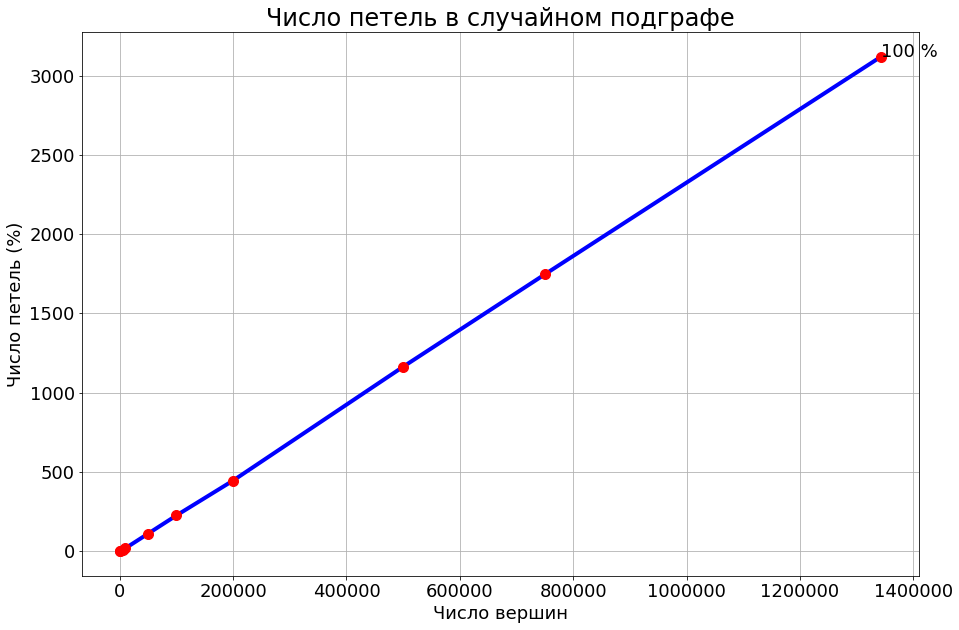

In [26]:
proportion = 1
count_direction_K2, sizes_subgraph = count_metric(G, get_loop, 'Число петель', proportion)

plt.figure(figsize=(15, 10))
custom_plot(
    sizes_subgraph, count_direction_K2,
    'Число петель в случайном подграфе',
    'Число петель (%)',
    str(proportion * 100) + ' %'
)

del count_direction_K2
del sizes_subgraph

Действительно, как ни пародоксально, но некоторые работы ссылаются сами на себя. Связано, скорее всего, это с двумя вещами:

* Ошибка в построении датасета
* Наглость автора (опять же, повышение индекса цитируемости)

### Трёхвершинные паттерны


Давайте рассмотрим все возможные конфигурации треугольников для орграфов. Для начала, выделим все типы треугольников без обратных связей (их 2). Рассмотрим первый из них:

![stagnation.png](stagnation.png)

Назовём такой треугольник **стагнация-3 ($S_3$)**, **мошенничество-3 ($F_3$)** или **циркуляция-3 ($C_3$)**. Эту конфигурацию будем связывать с конкретной вершиной и в зависимости от характеристик вершины, она будет приобретать одно из трёх названий. Такие названия поясним.

Поробуем предположить, что может означать такой паттерн. Он образует, как видно, цикл. Гипотетически, из этого может следовать, что выводы, которые сделаны в статье $A$ частично взяты из статьи $B$. Аналогичное заключение можно дать относительно пар ($B$, $C$) и ($C$, $A$). Таким образом, оказывается, что каждая из статей берёт от своего соседа кусочек информации и переписывает его. Следует отметить, что скорее всего такие статьи публикуются примерно в одно и то же время. В противном случае, ссылки такого рода кажутся крайне странными, поскольку, цикл порождает ссылку в далёкое будущее.

С одной стороны, этот паттерн можно расценивать как стагнацию (в случае, если таких циклов для вершины $X$ довольно много). Фактически это переписывание одной и той же информации. С другой стороны, это можно воспринять как очередную попытку повышения индекса цитируемости то бишь мошенничества. То есть три человека действуют в сговоре. Третьей интерпретацией может служить циркулирование информации между статьями. В последней формулировке, ровно как и в первой можно искать циклы длины $N$ для того, чтобы охарактеризовать, насколько сильно информация циркулирует между статьями (в случае малой доли циклов для вершины $X$), либо же, можно оценить степень стагнирования данной статьи (в случае большой доли циклов для вершины $X$), а также, степень стагнирования автора (взять во внимание все статьи).

Отметим, что природа такого цикла, скорее всего, связана с тем, что авторы знают друг друга и сослались на статьи ещё до официальной публикации работ в журналах или других источниках.

Резюмируем наше рассжудение:

* Большая доля ссылок входит в цикл длины $N\geq3$, то вершина **стагнирующая**, т.е. не превносит новой информации
* Небольшая доля ссылок входит в цикл длины $N\geq3$, то вершина **циркуляционная**, т.е. есть некоторый устойчивый паттерн в статье, о котором идёт речь
* **Мошенническая**. Цикл длины $N=3$. Критерий мошеннеческой статьи в данном случае сложно выработать. Скорее всего, он будет связан с большим количеством ссылок друг на друга определённой группы авторов. Для этого требуется дополнительное исследование.

Теперь рассмотрим следующий объект:

![generalization.png](generalization.png)

Его наречём **обобщение ($G_3$ от англ. generelization)**. Обобщением назовём данный паттерн по той причине, что у нас есть 1 вершина, на которую ссылаются 2 других. Таким образом, можно сделать предположение, что в двух из трёх работ происходит обобщение информации. Этот объект, также как и предыдущий, будем рассматривать только лишь относительно какой-нибудь вершины. В случае, изображённом на рисунке -- относительно вершины $A$. Т.е. $A$ является вершиной $G_3$.

Интересно взглянуть на число авторов, которые порождают такого рода статьи и пересекаются ли множества авторов для различных паттернов. Интересен также вопрос: как далеко отстоят вершины друг от друга по времени в паттернах выше.

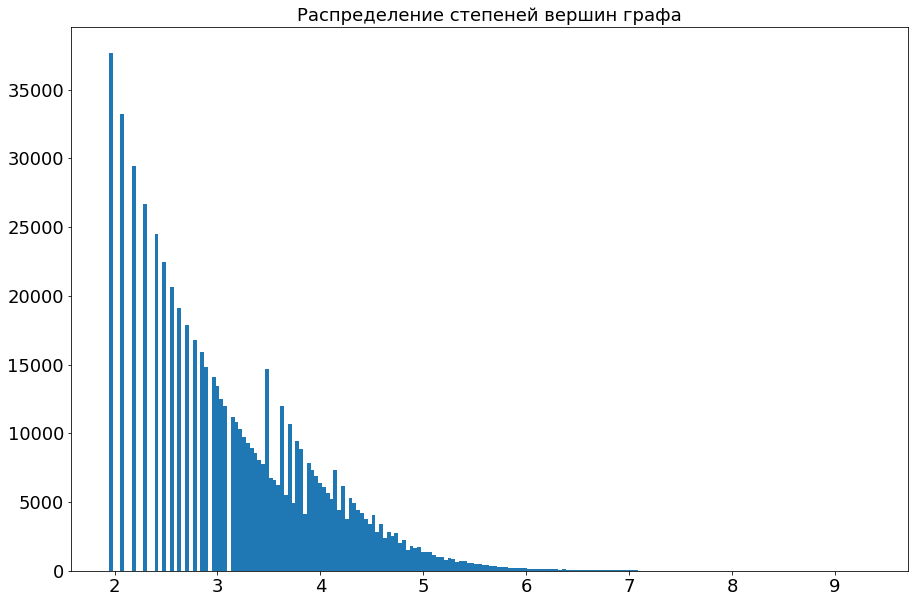

In [36]:
degs = []
for item in G.degree:
    degs.append(item[1])

plt.figure(figsize=(15,10))
plt.title('Распределение степеней вершин графа', fontsize=18)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(np.log1p(np.array(degs)[np.array(degs) > 5]), bins=200);

In [37]:
max_comp_sizes = []
mean_10_max_comp_size_without_first = []
second_comp_size = []
count_comps = []
density_subgraph = []
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, 1000000, len(G.nodes)]
m_cv = 5
vertexes = list(G.nodes)
for n in tqdm_notebook(sizes_subgraph):
    second_comp_size_ = []
    mean_10_max_comp_size_without_first_ = []
    for m in range(m_cv):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = list(np.array(vertexes)[perm])[:n]
        subgraph = G.subgraph(random_vertex)
        lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
        second_comp_size_.append(lens[1])
        mean_10_max_comp_size_without_first_.append(np.mean(lens[1:11]))
    second_comp_size.append(np.mean(second_comp_size_))
    mean_10_max_comp_size_without_first.append(np.mean(mean_10_max_comp_size_without_first_))
    
    lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
    max_comp_sizes.append(lens[0])
    count_comps.append(len(lens))
    density_subgraph.append((2 * len(subgraph.edges)) / (len(subgraph.nodes) * (len(subgraph.nodes) - 1)))
del subgraph
del vertexes

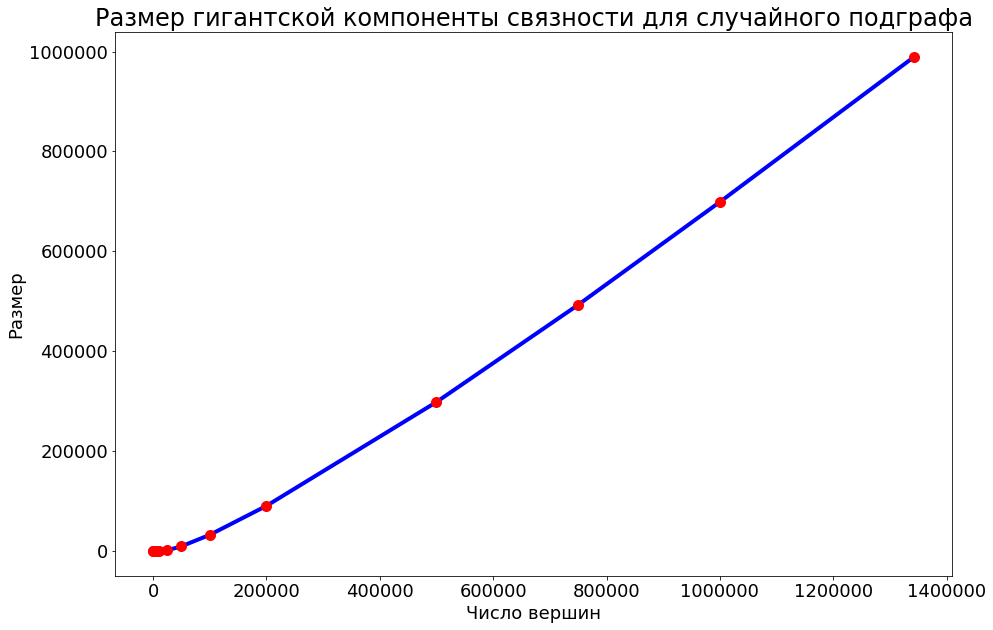

In [38]:
custom_plot(
    sizes_subgraph, max_comp_sizes,
    'Размер гигантской компоненты связности для случайного подграфа',
    'Размер'
)

Модель малого мира выполняется. Данный граф представляет собой большую компоненту, которая разростается с ростом числа вершин. Это и понятно: большее число статей охватывает большее количе

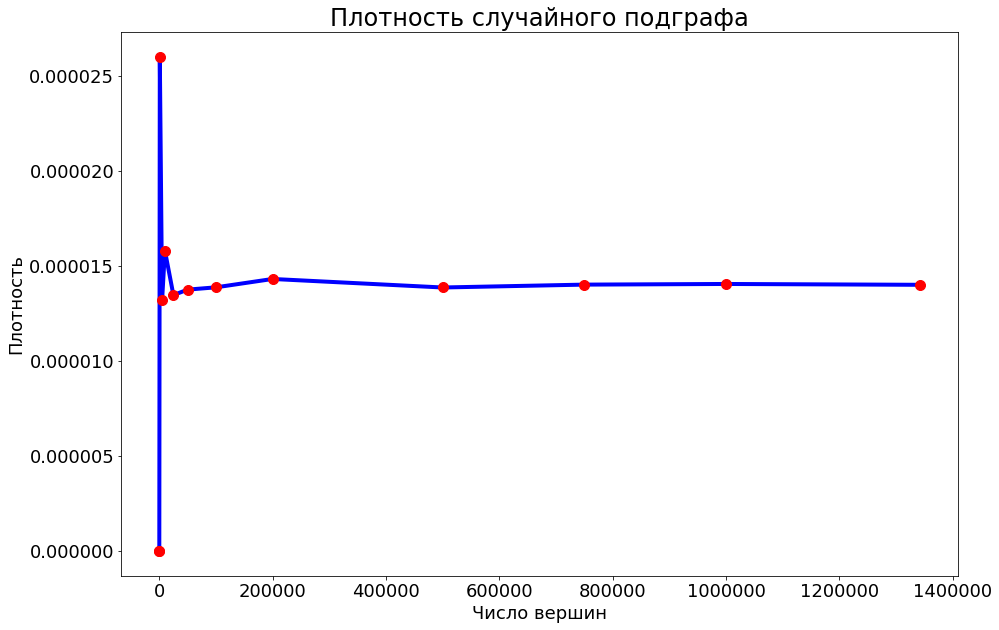

In [39]:
custom_plot(
    sizes_subgraph, density_subgraph,
    'Плотность случайного подграфа',
    'Плотность'
)

Отметим, что после того, как мы убрали "мелкие" кластеры, плотность графа выросла на 2 порядка

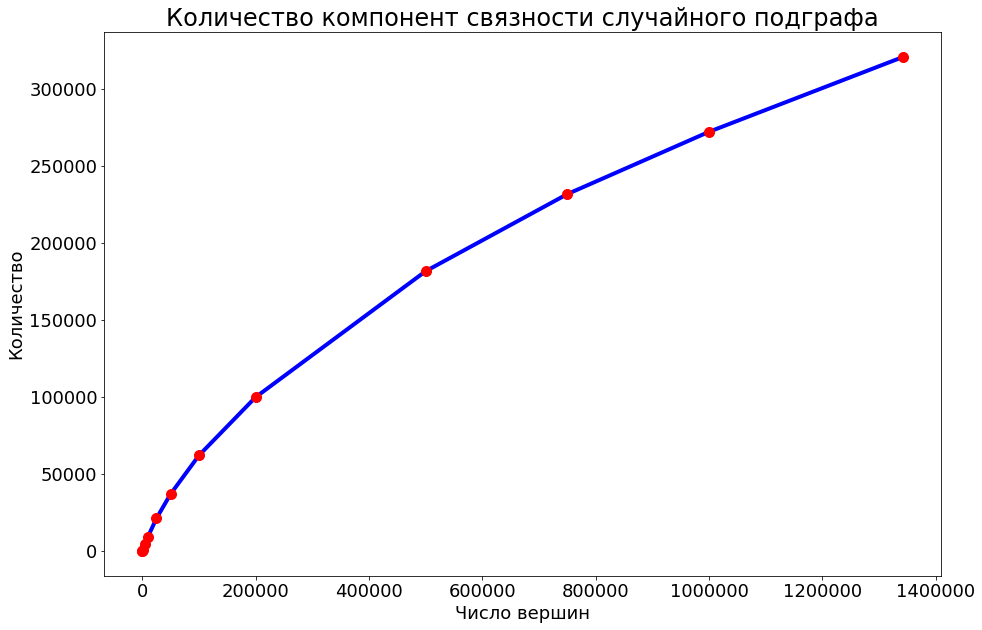

In [40]:
custom_plot(
    sizes_subgraph, count_comps,
    'Количество компонент связности случайного подграфа',
    'Количество'
)

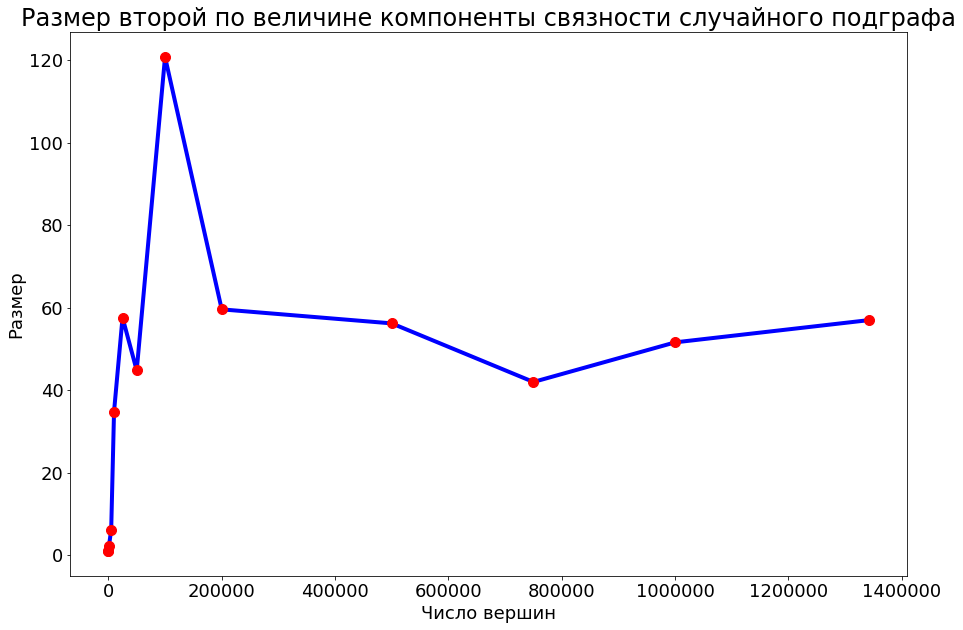

In [41]:
custom_plot(
    sizes_subgraph, second_comp_size,
    'Размер второй по величине компоненты связности случайного подграфа',
    'Размер'
)

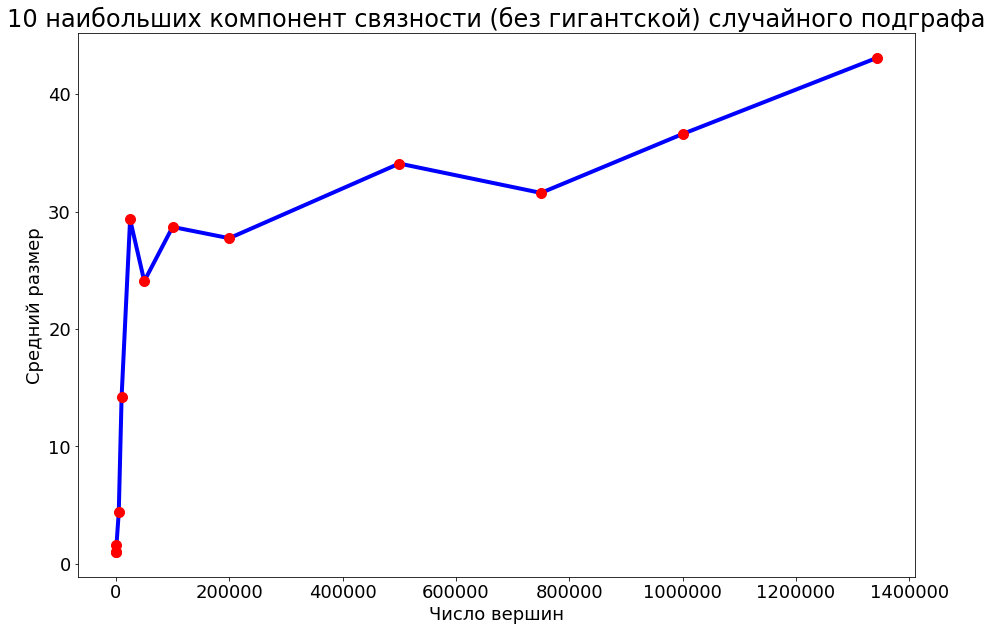

In [42]:
custom_plot(
    sizes_subgraph, mean_10_max_comp_size_without_first,
    '10 наибольших компонент связности (без гигантской) случайного подграфа',
    'Средний размер'
)

In [14]:
cc = sorted([c for c in list(nx.connected_components(G))], key=lambda el: len(el))[::-1][1:]
flatten_cc = []
for c in cc:
    for x in c:
        flatten_cc.append(x)
v_for_deleted = set(flatten_cc)

for doc in docs:
    edges = []
    for v in docs[doc][ArxivTags.Edges]:
        if v not in v_for_deleted:
            edges.append(v)
    docs[doc][ArxivTags.Edges] = edges
    
for doc in v_for_deleted:
    del docs[doc]
    
del cc
del flatten_cc
del v_for_deleted

In [19]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

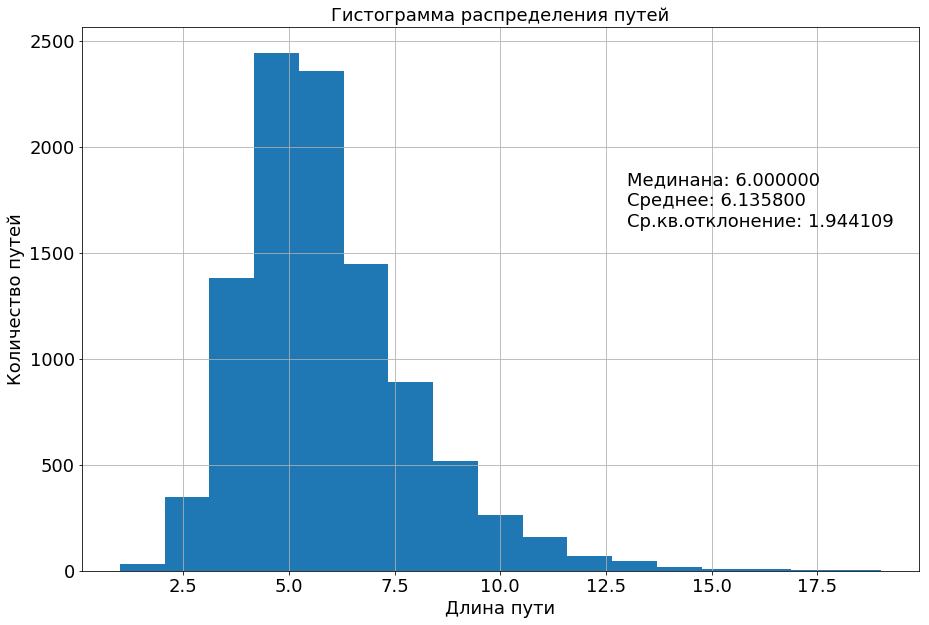

In [20]:
vertexes = list(G.nodes)
n_cv = 10000
len_paths = []
np.random.seed(42)
for i in tqdm_notebook(range(n_cv)):
    a = np.random.randint(len(vertexes))
    b = np.random.randint(len(vertexes))
    len_paths.append(nx.shortest_path_length(G, source=vertexes[a], target=vertexes[b]))
del vertexes

plt.figure(figsize=(15, 10))
plt.hist(len_paths, bins=17)
plt.grid(True)
plt.ylabel('Количество путей', fontsize=18)
plt.xlabel('Длина пути', fontsize=18)
plt.title('Гистограмма распределения путей', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.text(13, 1820, 'Мединана: %f' % np.median(len_paths), fontsize=18)
plt.text(13, 1720, 'Среднее: %f' % np.mean(len_paths), fontsize=18);
plt.text(13, 1620, 'Ср.кв.отклонение: %f' % np.sqrt(np.var(len_paths)), fontsize=18);

# Анализ графа по времени

In [64]:
del docs
del G

In [65]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:24<00:00,  1.15s/it]


In [26]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

In [27]:
docs_by_years = {}
for year in range(1991, 2018):
    docs_by_years[year] = []

for doc in docs:
    docs_by_years[docs[doc][ArxivTags.Year]].append(doc)

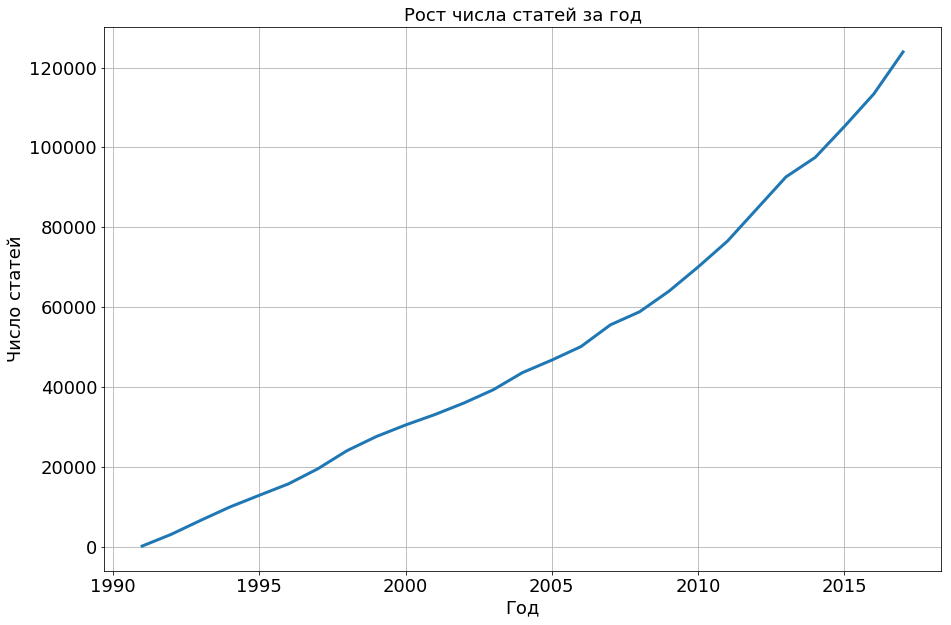

In [28]:
counts = [len(docs_by_years[y]) for y in docs_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts, linewidth=3)
plt.grid(True)
plt.ylabel('Число статей', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Рост числа статей за год', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

In [29]:
sorted_by_year_docs = []

for doc in docs:
    splitted = doc.split('/')
    if len(splitted) == 2:
        splitted = splitted[1]
        if int(splitted[:2]) > 90:
            year = 1900 + int(splitted[:2])       
        else:
            year = 2000 + int(splitted[:2])       
        year_month = year * 100 + int(splitted[2:4])
        year_month_num = year_month * 10000 + int(splitted[4:])
        year_month_num_r = year_month_num * 1000 + np.random.randint(100)
        sorted_by_year_docs.append((doc, year_month_num_r))
    else:
        splitted = splitted[0].split('.')
        a = splitted[0]
        b = splitted[1]
        year = 2000 + int(a[:2])       
        year_month = year * 100 + int(a[2:4])
        year_month_num = year_month * 100000 + int(b)
        sorted_by_year_docs.append((doc, year_month_num * 100))

In [30]:
max_comp_sizes = []
mean_10_max_comp_size_without_first = []
second_comp_size = []
count_comps = []
density_subgraph = []
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, 1000000, len(G.nodes)]
vertexes = list([item[0] for item in sorted_by_year_docs])
m_cv = 5
for n in tqdm_notebook(sizes_subgraph):
    second_comp_size_ = []
    mean_10_max_comp_size_without_first_ = []
    for m in range(m_cv):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = vertexes[:n]
        subgraph = G.subgraph(random_vertex)
        lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
        second_comp_size_.append(lens[1])
        mean_10_max_comp_size_without_first_.append(np.mean(lens[1:11]))
    second_comp_size.append(np.mean(second_comp_size_))
    mean_10_max_comp_size_without_first.append(np.mean(mean_10_max_comp_size_without_first_))
    
    lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
    max_comp_sizes.append(lens[0])
    count_comps.append(len(lens))
    density_subgraph.append((2 * len(subgraph.edges)) / (len(subgraph.nodes) * (len(subgraph.nodes) - 1)))
del subgraph
del vertexes

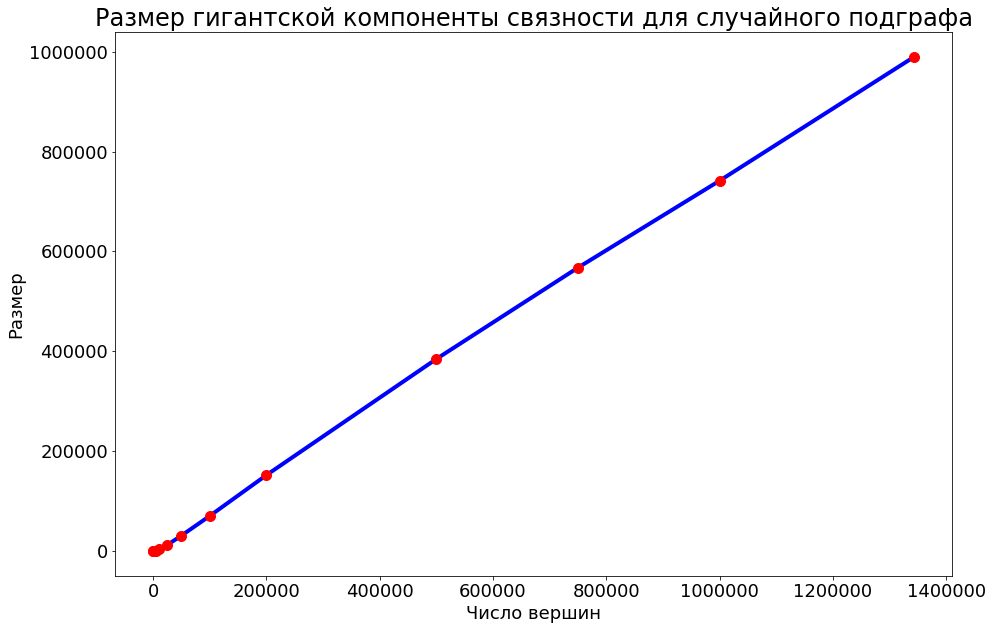

In [33]:
custom_plot(
    sizes_subgraph, max_comp_sizes,
    'Размер гигантской компоненты связности для случайного подграфа',
    'Размер'
)

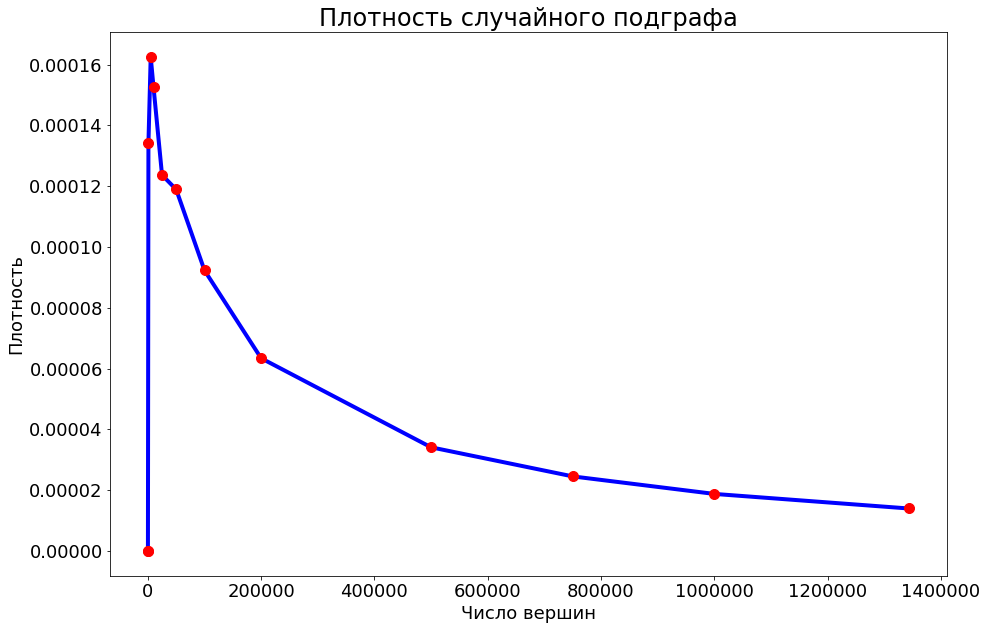

In [34]:
custom_plot(
    sizes_subgraph, density_subgraph,
    'Плотность случайного подграфа',
    'Плотность'
)

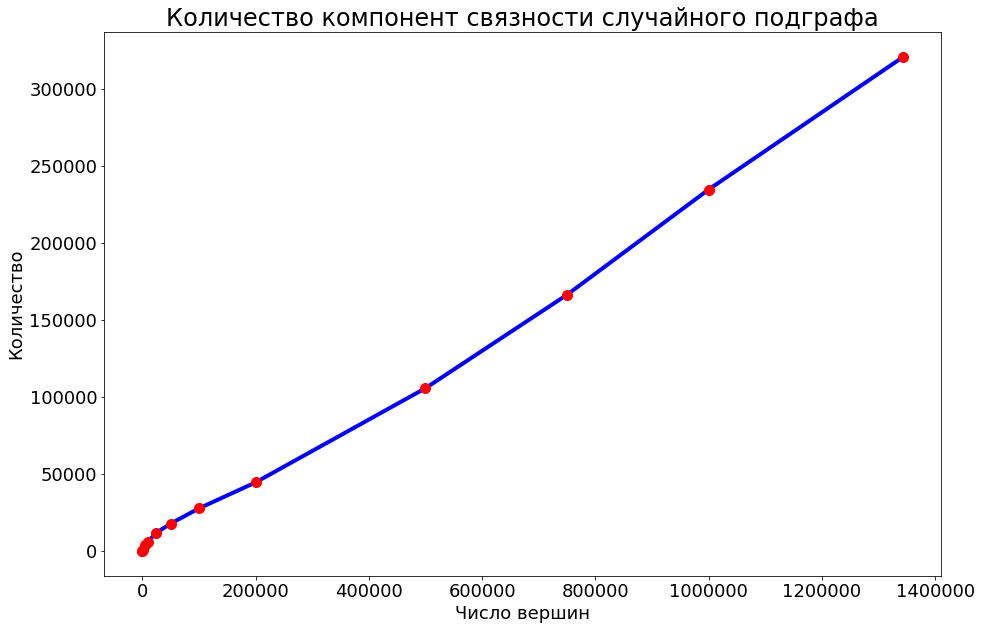

In [35]:
custom_plot(
    sizes_subgraph, count_comps,
    'Количество компонент связности случайного подграфа',
    'Количество'
)

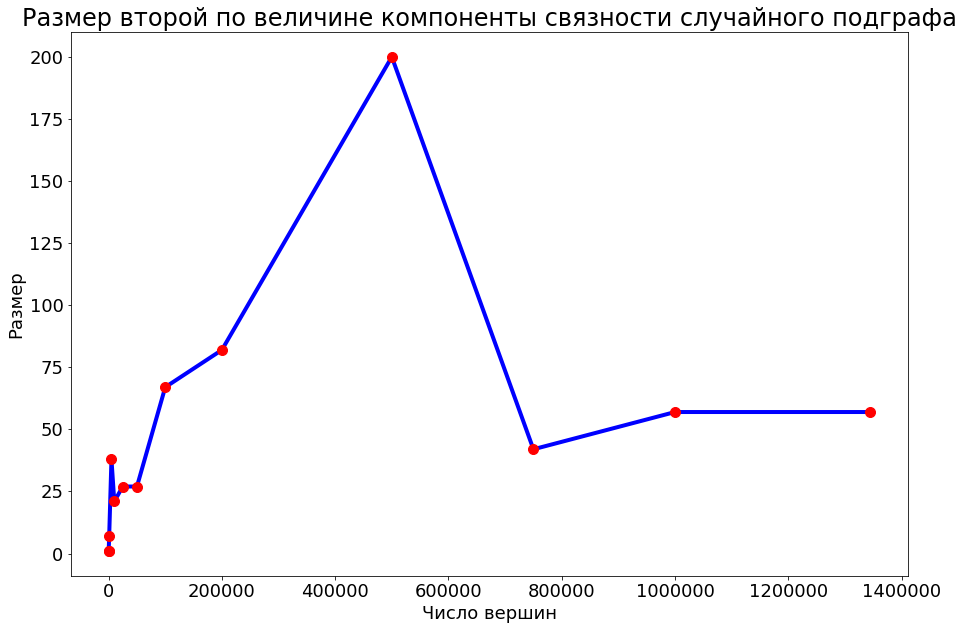

In [36]:
custom_plot(
    sizes_subgraph, second_comp_size,
    'Размер второй по величине компоненты связности случайного подграфа',
    'Размер'
)

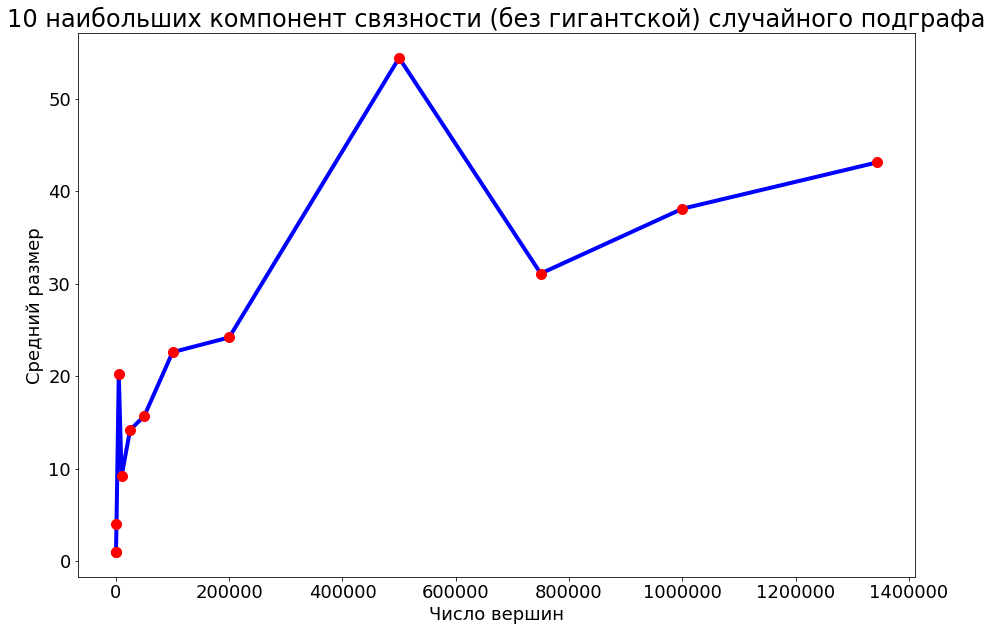

In [37]:
custom_plot(
    sizes_subgraph, mean_10_max_comp_size_without_first,
    '10 наибольших компонент связности (без гигантской) случайного подграфа',
    'Средний размер'
)

In [70]:
del docs

In [71]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:20<00:00,  1.22s/it]


In [72]:
for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.GeneralTags]:
        if tag in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.GeneralTags].add(tag.split('.')[0])
    for tag in old_tags:
        docs[doc][ArxivTags.GeneralTags].remove(tag)

for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.Tags]:
        if tag.split('.')[0] in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.Tags].add(tag)
    for tag in old_tags:
        docs[doc][ArxivTags.Tags].remove(tag)

In [75]:
theme_g = nx.Graph()
for doc in tqdm_notebook(docs):
    tags0 = docs[doc][ArxivTags.GeneralTags]
    tags1 = []
    for v in docs[doc][ArxivTags.Edges]:
        tags1 += docs[v][ArxivTags.GeneralTags]
    for t0 in tags0:
        if t0 in ['eess', 'econ']:
            continue
        for t1 in tags1:
            if t1 in ['eess', 'econ']:
                continue
            if theme_g.has_edge(t0, t1):
                theme_g[t0][t1]['weight'] += 1
                theme_g[t1][t0]['weight'] += 1
            else:
                theme_g.add_edge(t0, t1, weight=1)
                theme_g.add_edge(t1, t0, weight=1)

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


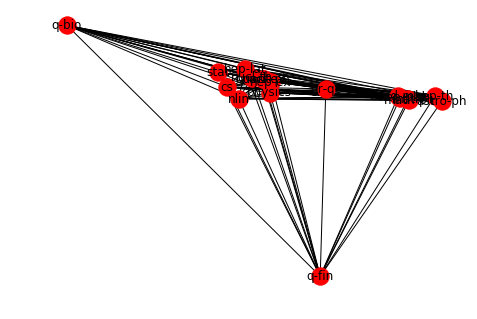

In [76]:
nx.draw(theme_g, with_labels=True)

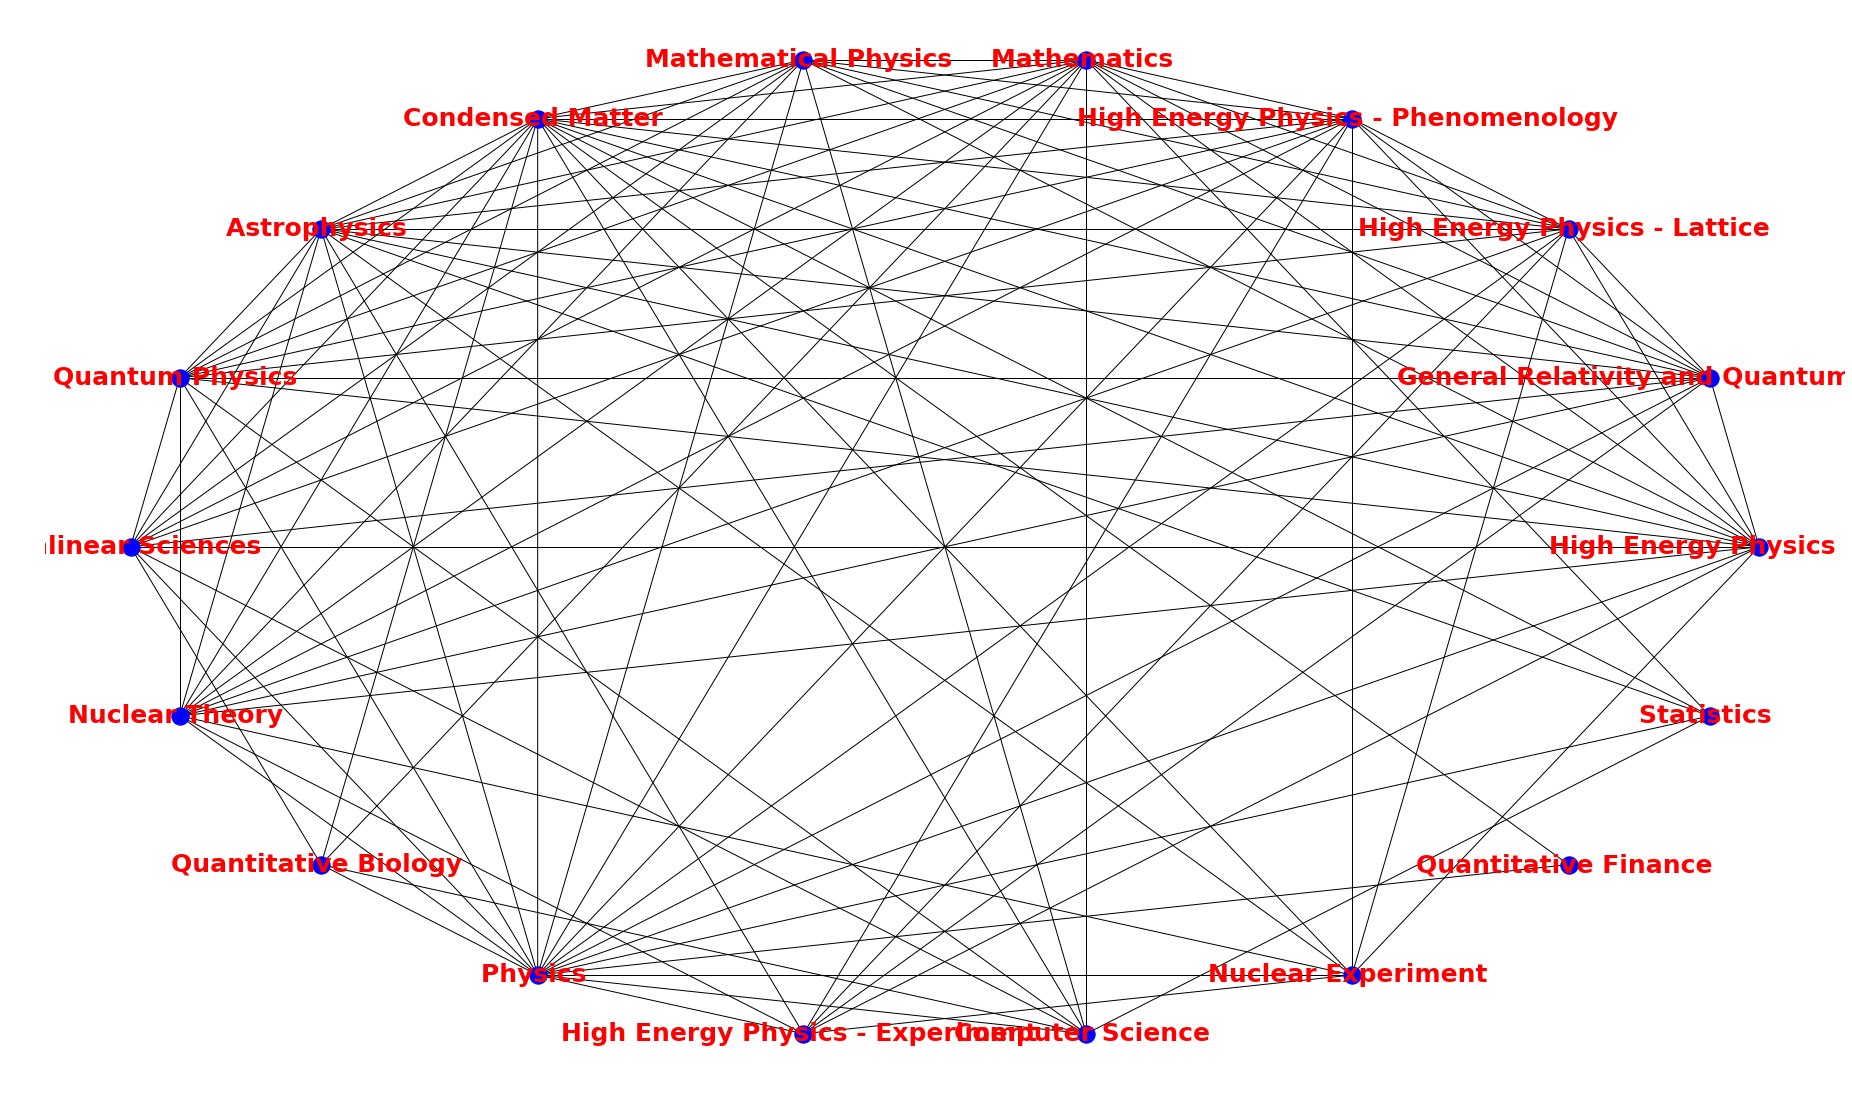

In [183]:
from copy import deepcopy
theme_g_new = deepcopy(theme_g)
theme_g_new = nx.relabel_nodes(theme_g_new, actuals)
t = 1000
for n0 in theme_g_new.nodes:
    for n1 in theme_g_new.nodes:
        if n1 in theme_g_new[n0] and theme_g_new[n0][n1]['weight'] < 10000:
            theme_g_new.remove_edge(n0, n1)
            
plt.figure(figsize=(25,15))
theme_g_new.remove_nodes_from(list(nx.isolates(theme_g_new)))
nx.draw_shell(theme_g_new, with_labels=True, font_size=25, font_color='red', font_weight=1000, node_color='blue')

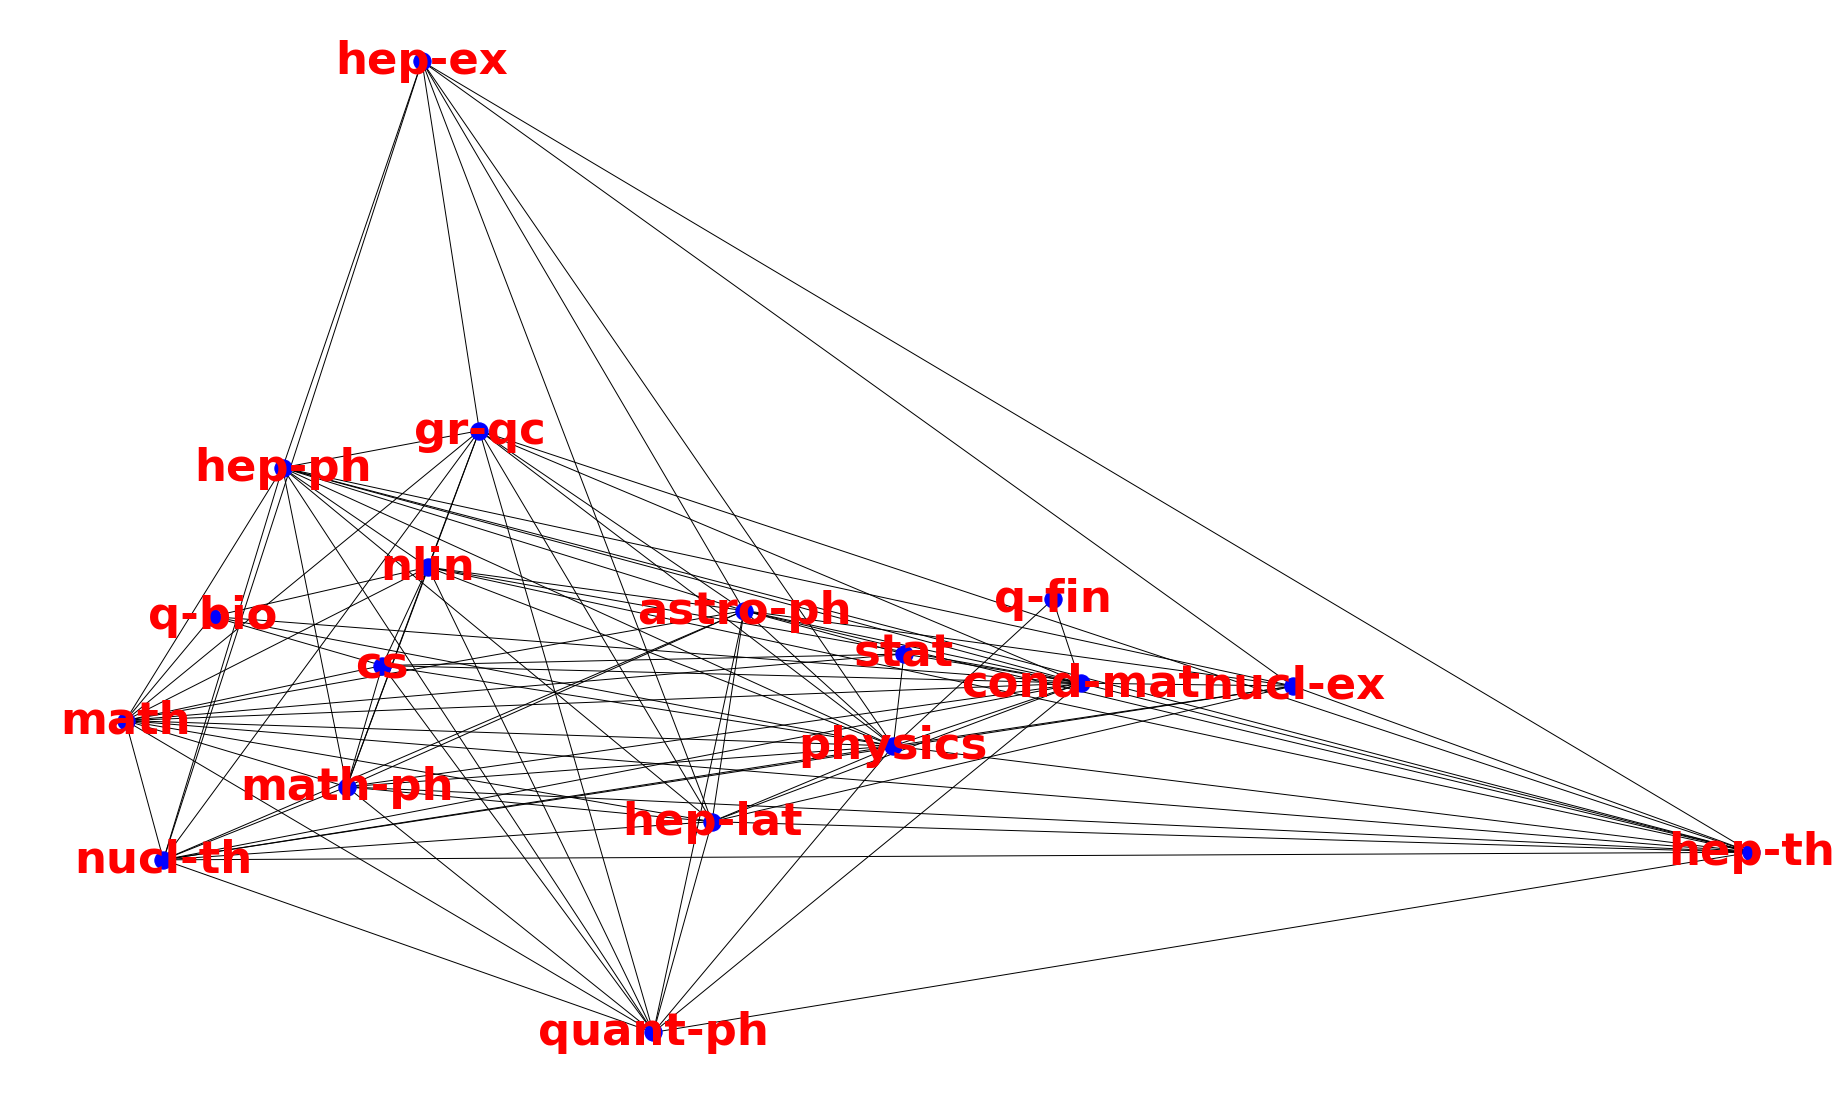

In [189]:
theme_g_new = nx.relabel_nodes(theme_g_new, {item[1]:item[0] for item in actuals.items()})

plt.figure(figsize=(25,15))
nx.draw_kamada_kawai(theme_g_new, with_labels=True, font_size=45, font_color='red', font_weight=1000, node_color='blue')